# Hierarchical Generation of Molecular Graphs using Structural Motifs

Here is the tutorial for the Hierarchical Generation of Molecular Graphs using Structural Motifs. It is in a vae framework. It is an upgrading form of the junction tree vae model which is introduced in another script. Instead of creating small junction tree motifs, it creates larger structural motifs which are more useful for larger molecules such as polymers. 

## The chemical utility functions

To understand what kind of chemical utility functions are needed, we need to understand how the motifs will be constructed. If a molecule is a graph G, then a motif is a subgraph of the molecule. In this algorithm, the author create disconnected fragments by breaking all the bridge bonds that will not violate chemical validity. Thus what we need to do is to create mol objects in rdkit, find the bridge bonds, edit on the raw mol to split into substructures by breaking the bonds.

### To be honest, the origin code is very difficult to understand as no comments at all. Thus I may not explain correctly

In [2]:
import rdkit
import rdkit.Chem as Chem
import torch
smiles = 'c1ccccc1'
mol = Chem.MolFromSmiles(smiles)
ring = [set(x) for x in Chem.GetSymmSSSR(mol)]
r = ring[0]
print(ring)

g = [None]
g.extend([None,None])
print(g)
# x =[(1,1),(1,2)]
# x = torch.IntTensor(x)
# print(x)
tensor1 = torch.ones((100,100), dtype=torch.int8)
print(tensor1)
data = [[0, 1], [2, 3]]
r = tensor1.new_tensor(data)
print(r)
# cluster = []
# cluster.append(set([1,2]))
# cluster.append(set([2,1]))
# print(cluster)
# node = [1,2,3,4]
# print(max(node))
# mol = Chem.MolFromSmiles('C1NCN1')
# rank = Chem.CanonicalRankAtoms(mol, breakTies=False)
# print(rank)
# for i in rank:
#     print(type(i))
# x=torch.ge(torch.tensor([[1, 2], [3, 4]]), torch.tensor([[1, 1], [4, 4]])).long()
# print(x)
# !pip install networkx[default]
# import networkx as nx
# graph = nx.empty_graph( 10 ) 

# graph.add_edge(2, 3, weight = 1)
# graph.add_edge(3, 2, weight = 1)
# graph.add_edge(2, 4, weight = 5)
# print(graph.edges)
# graph=nx.DiGraph(graph)
# print(graph.edges)
# graph.add_node(11)
# graph[2][3]['label'] = 0
# graph[3][2]['label'] = 1
# graph.nodes
# print(graph[2])
# print(graph[3])
# list1=[ y for y in graph[2] if y != -1 ]
# print(list1)
# for idx,y in enumerate([]):
#     print(idx)
#     print(y)
# prev_sib = [[0,1]]
# cluster = [[1,2,3],[4,5,6],[7,8,9]]
# hist = [a for c in prev_sib[0] for a in cluster[c]]
# print(len(cluster[0]))



[{0, 1, 2, 3, 4, 5}]
[None, None, None]
tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1]], dtype=torch.int8)
tensor([[0, 1],
        [2, 3]], dtype=torch.int8)


/home/lijiali/anaconda3/envs/Tutorial/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


One important thing to keep in mind is that we need to construct a molecule tree. Which means a large molecule will be divided as a tree of different motifs. Here the graph structure of a molecule is converted into a tree structure. Where each node is a motif. 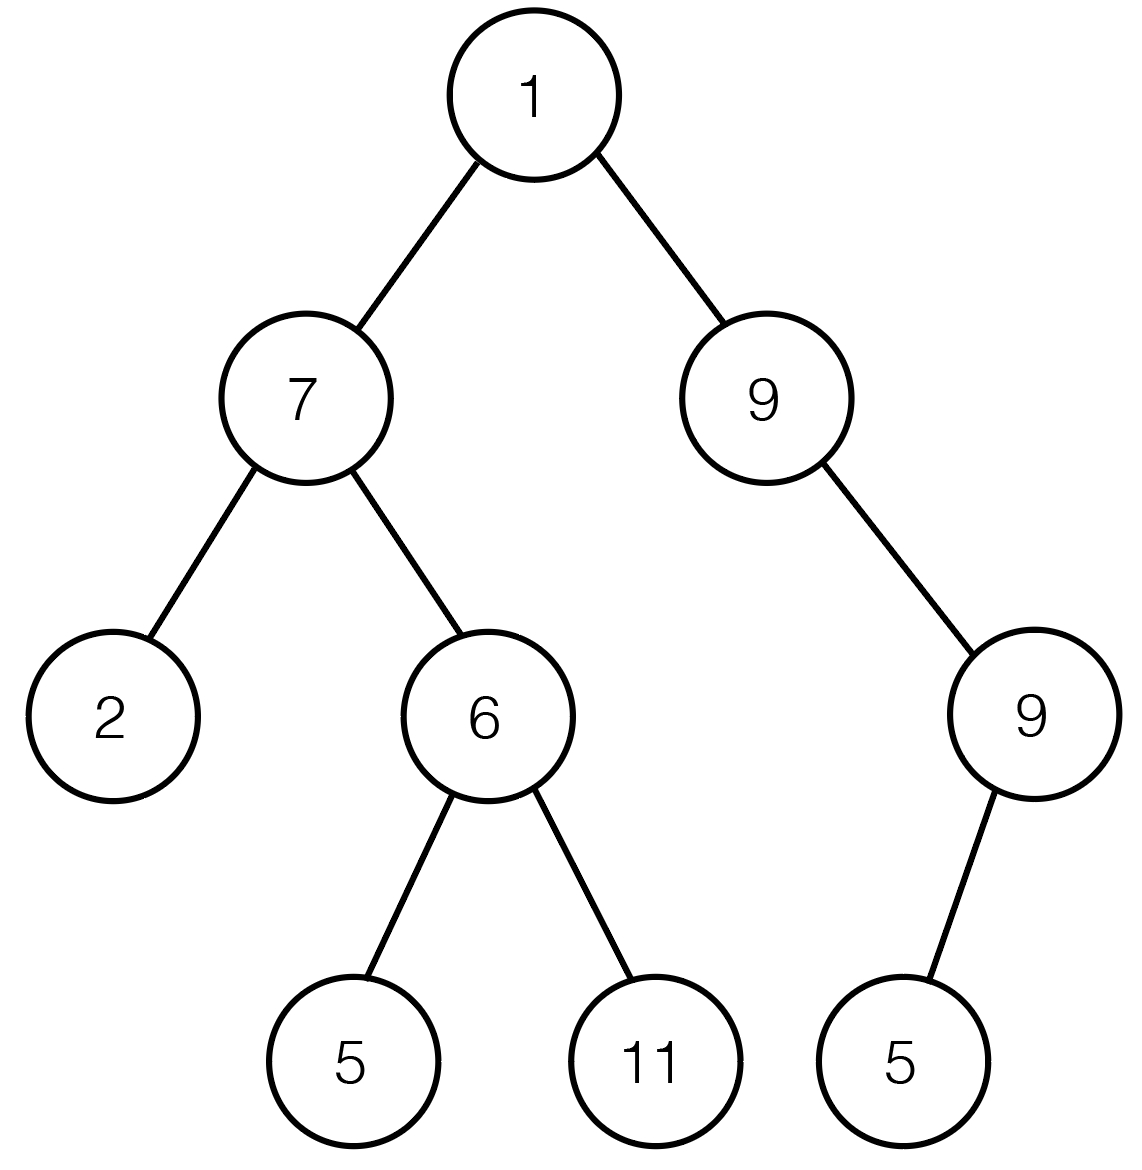


In [3]:
import rdkit
import rdkit.Chem as Chem
from collections import defaultdict

lg = rdkit.RDLogger.logger() 
lg.setLevel(rdkit.RDLogger.CRITICAL)

idxfunc = lambda a : a.GetAtomMapNum() - 1 # a is an atom object

def set_atommap(mol, num=0):
    # create atom mapping for atoms inside molecule, normally useful for reactions since there are transformation of a mol
    # For Hgraph since we need to extract motifs from original molecules, it is like triggering a reaction
    # the mol will be splitted into motifs, thus the atommap can record where the atom comes from
    for atom in mol.GetAtoms():
        atom.SetAtomMapNum(num)
    return mol

def get_mol(smiles):
    # get mol from smiles and kekulize them
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None: Chem.Kekulize(mol)
    return mol

def get_smiles(mol):
    return Chem.MolToSmiles(mol, kekuleSmiles=True)

def sanitize(mol, kekulize=True):
    # The typical workflow of sanitize molecules
    try:
        smiles = get_smiles(mol) if kekulize else Chem.MolToSmiles(mol)
        mol = get_mol(smiles) if kekulize else Chem.MolFromSmiles(smiles)
    except:
        mol = None
    return mol

def is_aromatic_ring(mol):
    # judge whether a bond in a mol is an aromatic ring and return a list of all aromatic bonds
    if mol.GetNumAtoms() == mol.GetNumBonds(): 
        aroma_bonds = [b for b in mol.GetBonds() if b.GetBondType() == Chem.rdchem.BondType.AROMATIC]
        return len(aroma_bonds) == mol.GetNumBonds()
    else:
        return False

def get_leaves(mol):
    '''
    This function is aiming to get the list of leaf atom and leaf rings (i.e., in terms of a representative atom in the ring)
    '''
    
    leaf_atoms = [atom.GetIdx() for atom in mol.GetAtoms() if atom.GetDegree() == 1]# This line is aiming at firstly get a list of atoms inside a molecule that have only 1 bonded neighbor in the graph
    # if only have 1 neighbour, then in a tree it is a leaf node

    clusters = []
    for bond in mol.GetBonds(): # This for loop is trying to get all bonds that are not in any rings in the form of (Begin_atom_index, End_atom_index) to form a list
        a1 = bond.GetBeginAtom().GetIdx()
        a2 = bond.GetEndAtom().GetIdx()
        if not bond.IsInRing():
            clusters.append( set([a1,a2]) )

    rings = [set(x) for x in Chem.GetSymmSSSR(mol)]
    # Chem.GetSymmSSSR(mol) is used to get a symmetrized SSSR for a molecule. It will return a sequence of sequences containing the rings found as atom ids
    #rings = [{1,3,4},{2,4,5}.....]
    # Here the rings are only single rings since GetSymmSSSR will only return single rings. The beehive structure will not be returned
    # Set is used to avoid repeated atoms in a ring which may due to any bugs
    
    
    clusters.extend(rings)
    # The extend will combine the two list, so cluster will be [{1,2},{2,3},...,{1,3,4},{2,4,5}.....]
    # it is a list of bonds and rings. All represented in terms of atom idx.

    leaf_rings = []
    for r in rings: # for each ring in rings (for each set of atoms in the list rings)
        inters = [c for c in clusters if r != c and len(r & c) > 0] # For all the set of atoms in clusters, if the ring is not equal to the set of atoms and the intersection
        # between the ring and the set of atoms in clusters is larger 1. inters list will store the intersection. 
        # Basically it is a list to record the set of bonds and rings that are connected to another rings in the molecule
        if len(inters) > 1: continue 
        # if a ring is connected to more than one bond or ring, then it is not a leaf ring, thus we will skip this ring
        
        nodes = [i for i in r if mol.GetAtomWithIdx(i).GetDegree() == 2]
        # atom with degree = 2 means the atom is only in the ring and doesn't connect to any other parts. 
        # in a benzene ring all the atoms in the ring has a degree of 2. It is trying to exclude the atom connect to other part.
        leaf_rings.append( max(nodes) ) #use max node index to represent a leaf ring

    return leaf_atoms + leaf_rings #a list containing different atoms index

def atom_equal(a1, a2):
    #judge two atom equal or not
    return a1.GetSymbol() == a2.GetSymbol() and a1.GetFormalCharge() == a2.GetFormalCharge()

def bond_match(mol1, a1, b1, mol2, a2, b2):
    #judge two bonds in different mol equal or not. Compare their atoms
    a1,b1 = mol1.GetAtomWithIdx(a1), mol1.GetAtomWithIdx(b1)
    a2,b2 = mol2.GetAtomWithIdx(a2), mol2.GetAtomWithIdx(b2)
    return atom_equal(a1,a2) and atom_equal(b1,b2)

def copy_atom(atom, atommap=True):
    '''
    atom: atom object
    atommap: boolen
    '''
    # copy an atom give it the right charge, atom map and symbol
    new_atom = Chem.Atom(atom.GetSymbol())
    new_atom.SetFormalCharge(atom.GetFormalCharge())
    if atommap: 
        new_atom.SetAtomMapNum(atom.GetAtomMapNum())
    return new_atom

#mol must be RWMol object, since we need to edit it
def get_sub_mol(mol, sub_atoms):
    '''
    This function aim to extract sub_atoms from an original mol to form a new mol 
    mol: mol object
    sub_atoms: a list of atom idx
    '''
    new_mol = Chem.RWMol()
    atom_map = {}
    for idx in sub_atoms:
        # This for loop is to add atom
        atom = mol.GetAtomWithIdx(idx)
        atom_map[idx] = new_mol.AddAtom(atom) 
        #The rwmol.addatom will return the index of the added atom.
        #Thus the atom_map dictionary will map the idx of atom in original mol to the new idx of atom in the new mol

    sub_atoms = set(sub_atoms)
    for idx in sub_atoms:
        # This for loop is to add bond between the atoms
        a = mol.GetAtomWithIdx(idx) # get the atom object with the idx in original mol
        for b in a.GetNeighbors(): # find the neighbor atoms to a
            if b.GetIdx() not in sub_atoms: continue # if b not in the sub_atoms set then skip 
            bond = mol.GetBondBetweenAtoms(a.GetIdx(), b.GetIdx()) # if b is in sub_atom set, get the original bond between a and b
            bt = bond.GetBondType() # get the bond type
            if a.GetIdx() < b.GetIdx(): #each bond is enumerated twice, so only keep one bond
                new_mol.AddBond(atom_map[a.GetIdx()], atom_map[b.GetIdx()], bt) # add the bond in the new mol.

    return new_mol.GetMol() #return the new mol object

def copy_edit_mol(mol):
    '''
    This function is used to copy a mol, to keep the attributes of atoms and bonds all the same
    Also the topology of the mol is kept the same as well. However, the mol's form is changed into a RWMol that can be
    edited
    mol: mol object 
    '''
    new_mol = Chem.RWMol(Chem.MolFromSmiles(''))
    for atom in mol.GetAtoms():
        new_atom = copy_atom(atom)
        new_mol.AddAtom(new_atom)

    for bond in mol.GetBonds():
        a1 = bond.GetBeginAtom().GetIdx()
        a2 = bond.GetEndAtom().GetIdx()
        bt = bond.GetBondType()
        new_mol.AddBond(a1, a2, bt)
        #if bt == Chem.rdchem.BondType.AROMATIC and not aromatic:
        #    bt = Chem.rdchem.BondType.SINGLE
    return new_mol

def get_clique_mol(mol, atoms):
    '''
    This function is aiming to extract a fragment of a mol and then transform the fragment into
    writable form
    mol: mol object 
    atoms: a list of atom idx
    '''
    smiles = Chem.MolFragmentToSmiles(mol, atoms, kekuleSmiles=True) 
    # Directly extract the fragments with a list of atoms from a molecule then return the smiles of the fragments
    new_mol = Chem.MolFromSmiles(smiles, sanitize=False)
    new_mol = copy_edit_mol(new_mol).GetMol() #make the fragment can be edited
    new_mol = sanitize(new_mol)  
    #if tmp_mol is not None: new_mol = tmp_mol
    return new_mol

def is_anchor(atom, inter_atoms):
    '''
    If the atom is in inter_atoms and its neighbor not in the inter_atoms, it is an anchor atom
    Here the inter_atoms is the intersection atoms between two clusters. 
    One complex thing the inter_atoms idx is not same as the AtomMapNum.
    The detail of the function usage is in the mol_tree part.
    '''
    for a in atom.GetNeighbors():
        if idxfunc(a) not in inter_atoms:
            return True
    return False

def get_anchor_smiles(mol, anchor, idxfunc=idxfunc):
    '''
    Here will get the smiles of a molecule that has atommap. Only anchor atom is marked as 1
    all other atoms are marked as 0
    for example: B1=BB=BB=B[B:1]=BB=BB=B1
    '''
    copy_mol = Chem.Mol(mol)
    for a in copy_mol.GetAtoms():
        idx = idxfunc(a)
        if idx == anchor: a.SetAtomMapNum(1)
        else: a.SetAtomMapNum(0)

    return get_smiles(copy_mol)

def get_inter_label(mol, atoms, inter_atoms):
    '''
    mol: the original mol
    atoms: a list of atoms, actually they are the clusters
    inter_atoms: the intersection atoms between the cluster and its parent cluster
    
    Return:
    new_mol: the cluster as a new mol, which is a motif
    inter_label: a list of tuple of 
    (the atom idx of the anchor intersection atoms between the cluster and its parent cluster in the new mol,
    the smiles with the anchor atom's map num set to be 1)
    '''
    new_mol = get_clique_mol(mol, atoms) # get the fragment of mol
    if new_mol.GetNumBonds() == 0: # This means the fragment contains single atoms
        inter_atom = list(inter_atoms)[0] 
        # The intersection atom is the first atom in the inter_atoms list, since only one atom
        for a in new_mol.GetAtoms(): 
            a.SetAtomMapNum(0) # set the atom number of all atoms in the fragments to be 0
        return new_mol, [ (inter_atom, Chem.MolToSmiles(new_mol)) ]
        # the fragment, [(the intersection atom, the smiles of the fragment)]

    inter_label = []
    for a in new_mol.GetAtoms():
        idx = idxfunc(a) # idx = atommap_num - 1, this will make atom_idx == atommap num
        if idx in inter_atoms and is_anchor(a, inter_atoms): 
            # the atom itself is in inter_atoms, and its neighbors are not all in inter_atoms，it is the anchor
            inter_label.append( (idx, get_anchor_smiles(new_mol, idx)) )
            # get a list of intersection atom's label [(idx of the anchor atom, the smiles of the new_mol with only the anchor atom has atommap_num=1 other atoms' mapnum =0)]

    for a in new_mol.GetAtoms():
        a.SetAtomMapNum( 1 if idxfunc(a) in inter_atoms else 0 ) # set all atom in inter_atoms list to have atommap_num = 1
    return new_mol, inter_label 

'''
        for i,cls in enumerate(self.clusters):
            inter_atoms = set(cls) & set(self.clusters[pa[i]]) if pa[i] >= 0 else set([0])
            # get the intersection atoms between current cluster and its parent cluster
            cmol, inter_label = get_inter_label(mol, cls, inter_atoms) 
            if pa[i] >= 0 and len(self.clusters[ pa[i] ]) > 2: 
                # when the parent of current cls is a cluster with more than 2 atoms
                hist = [a for c in prev_sib[i] for a in self.clusters[c]]
                # hist shall be history, it will be a list of all atoms in the previous_slibling clusters to the current cluster
                # all the atoms will be visted before the atoms in current cluster
                pa_cls = self.clusters[ pa[i] ] # the parent cluster
                tree.nodes[i]['assm_cands'] = get_assm_cands(mol, hist, inter_label, pa_cls, len(inter_atoms)) 
'''


def get_assm_cands(mol, atoms, inter_label, cluster, inter_size):
    '''
    This function is trying to deal with motif trees
    mol: mol object - the whole molecule
    atoms: a list of atoms idx in the previous_slibling + parent clusters of the current cluster， hist
    inter_label: a list of tuple of 
    (the atom idx of the anchor intersection atoms between the cluster and its parent cluster in the new mol,
    the smiles with the anchor atom's map num set to be 1)
    cluster: list of atoms in parent cluster, pa_cls
    inter_size: total number of intersection atoms between current cluster and parent cluster
    '''
    atoms = list(set(atoms)) # get a list of atoms index containing all atoms in prev_slibings of current cluster
    mol = get_clique_mol(mol, atoms) # get the fragment of all the atoms that has been visited before at the same level 
    atom_map = [idxfunc(atom) for atom in mol.GetAtoms()] 
    #get the atom idx number of atoms in fragment where atommap number - 1, it will be the atom map num in original molecule rather than the new fragment
    mol = set_atommap(mol) # reset all the atomnum in the fragment to be 0
    rank = Chem.CanonicalRankAtoms(mol, breakTies=False)
    # it returns the canonical atom ranking for each atom of a molecule fragment 
    # based on chemical environment and so on. 
    # in this paper Get Your Atoms in Order—An Open-Source Implementation of a Novel and Robust Molecular Canonicalization Algorithm
    # If breakTies is False, this returns the symmetry class for each atom. 
    # return a list of idx
    # The symmetry class is used by the canonicalization routines to type each atom based on the whole chemistry of the molecular graph. 
    # Any atom with the same rank (symmetry class) is indistinguishable. 
    # rank is an iterable object, when iterate through it each number is in int type
    rank = { x:y for x,y in zip(atom_map, rank) }
    # create a rank dictionary map the atom_idx in original molecule to rank number which is the atom_idx in the current mol fragment

    pos, icls = zip(*inter_label) 
    #zip the unpack of list inter_label. Get two tuples, the first one contains the atom_idx in the original mol of all anchor atoms
    # the second one contain the smiles for only that anchor atom is set as atommap num = 1 for the fragment
    if inter_size == 1:
        # print('cluster:')
        # print(cluster)
        # print('/n rank:' )
        # print(rank)
        cands = [pos[0]] + [ x for x in cluster if rank[x] != rank[pos[0]] ] 
        # print('cands')
        # print(cands)
        # the cluster in second list is the parent cluster and the rank is for sblings and parent
        # [anchor atom_idx in original mol,all atoms idx in the parent cluster if this atom is not the anchor atom ]
        # it means actually for intersection at a single atom, we think we can attach it to all the atom positions except the symetry position of anchor of the parent cluster
    
    elif icls[0] == icls[1]: #symmetric case intersection at two positions
        shift = cluster[inter_size - 1:] + cluster[:inter_size - 1]
        cands = zip(cluster, shift)
        cands = [pos] + [ (x,y) for x,y in cands if (rank[min(x,y)],rank[max(x,y)]) != (rank[min(pos)], rank[max(pos)]) ]
    else: 
        shift = cluster[inter_size - 1:] + cluster[:inter_size - 1]
        cands = zip(cluster + shift, shift + cluster)
        cands = [pos] + [ (x,y) for x,y in cands if (rank[x],rank[y]) != (rank[pos[0]], rank[pos[1]]) ]

    return cands




            


## The below cell is for constructing molecule graph object
The mol_graph is for atom layer information and The mol_tree is for motif layer information, the attachment layer information is in the mol_tree and 

In [4]:
import torch
import rdkit
import rdkit.Chem as Chem
import networkx as nx


add = lambda x,y : x + y if type(x) is int else (x[0] + y, x[1] + y)

class MolGraph(object):
    # This class is aiming to construct a mol graph and mol tree
    # The graph build is very easy by using the nx package.
    # The attribute of atom store symbol and charge
    # The attribute of edge store bond type idx

    BOND_LIST = [Chem.rdchem.BondType.SINGLE, Chem.rdchem.BondType.DOUBLE, Chem.rdchem.BondType.TRIPLE, Chem.rdchem.BondType.AROMATIC] 
    MAX_POS = 20

    def __init__(self, smiles):
        self.smiles = smiles
        self.mol = get_mol(smiles)

        self.mol_graph = self.build_mol_graph() #It is the molecule graph
        self.clusters, self.atom_cls = self.find_clusters()  # it gives two lists, 1st contain all clusters, 2nd contain each atom appear in which clusterss
        self.mol_tree = self.tree_decomp() # The mol_tree is based on clusters
        self.order = self.label_tree()

    def find_clusters(self):
        '''
        This function is aiming to find clusters inside a molecule
        The cluster is defined by bonds, when atom 1 connect with atom 2 and the bond connected them is 
        not in a ring then (a1,a2) is a small cluster, the ring cluster is get by using Chem.GetSymmSSSR(mol)
        cluster = [(),(),(),....] record all clusters in a mol in terms of a list of tuples of atom_idx
        atom_cluster = [[],[],[],...] record the atom appear in which cluster
        '''
        mol = self.mol
        n_atoms = mol.GetNumAtoms()
        if n_atoms == 1: #special case
            return [(0,)], [[0]]

        clusters = []
        for bond in mol.GetBonds():
            # Get all small clusters without bonds in rings
            a1 = bond.GetBeginAtom().GetIdx()
            a2 = bond.GetEndAtom().GetIdx()
            if not bond.IsInRing():
                clusters.append( (a1,a2) )

        ssr = [tuple(x) for x in Chem.GetSymmSSSR(mol)] #Get all SSSR ring cluster with atom index (a1,a4,a6)..., 
        # better read this to gain more understanding https://depth-first.com/articles/2020/08/31/a-smallest-set-of-smallest-rings/
        clusters.extend(ssr)

        if 0 not in clusters[0]: #root is not node[0] # this is strange case where the bond doesnt loop from a root atom
            for i,cls in enumerate(clusters):
                if 0 in cls:
                    clusters = [clusters[i]] + clusters[:i] + clusters[i+1:] 
                    # move the cluster with root atom into the begining of the cluster list
                    #clusters[i], clusters[0] = clusters[0], clusters[i]
                    break

        atom_cls = [[] for i in range(n_atoms)]
        for i in range(len(clusters)):
            for atom in clusters[i]:
                atom_cls[atom].append(i) # record the atom appear in which cluster

        return clusters, atom_cls

    def tree_decomp(self):
        clusters = self.clusters
        graph = nx.empty_graph( len(clusters) ) # will create an empty graph on len(clusters) nodes. 
        for atom, nei_cls in enumerate(self.atom_cls): # one atom can appear in several clusters 
        # '''
        # actually the variable nei_cls is misleading. It is not neighbor cluster. it is all the clusters
        # the atom appear in. 
        # '''
            if len(nei_cls) <= 1: continue # if only appear in one or zero cluster then continue
            bonds = [c for c in nei_cls if len(clusters[c]) == 2]  
            # if the cluster the atom is in has a length of 2, then the cluster is a bond cluster
        
            rings = [c for c in nei_cls if len(clusters[c]) > 2] #need to change to 2 
            # I think it should be 2 since the smallest ring is size = 3, however, in molecules >4 should be fine to cover most of the cases
            # if the cluster the atom is in has a length of bigger than 2, then the cluster is a ring cluster
        # '''
        # The above code is trying to firstly find an intersection atom. Then record what clusters it is in
        # and what are the types of the clusters
        # '''

            if len(nei_cls) > 2 and len(bonds) >= 2:
                # if an atom appear in more than two clusters and among them there are more than or equal to 2 bond cluster
                clusters.append([atom]) # add the atom itself as a cluster into the cluster list
                c2 = len(clusters) - 1 
                # get the length of the cluster list and - 1, actually it is aiming to get the index of the new single
                # atom cluster we added
                graph.add_node(c2) # add the new single atom cluster as a node in the graph, the original graph has only the original number
                
                for c1 in nei_cls:
                    # add edge with weight = 100 between the new single atom cluster with the 
                    # clusters this atom appeared in mainly should be bond clusters
                    graph.add_edge(c1, c2, weight = 100)
            # '''
            # The above if loop is aiming at firstly identify the atoms that belong to more than or equal to
            # 2 bond clusters and make it a new cluster add into the end of the cluster list. Then add this cluster
            # as a node in the empty graph which shall be a tree. Then this node is connected to the all other clusters
            # this atom belong
            # '''

            elif len(rings) > 2: 
                #Bee Hives, len(nei_cls) > 2 if the atom appear in more than two rings actually it is not beehive
                # it just treat the same as an atom is appear in more than 3 clusters to avoid cycles in the tree
                clusters.append([atom]) #temporary value, need to change # same add the atom itself as a cluster into the cluster list
                c2 = len(clusters) - 1 # same as above if branch
                graph.add_node(c2) # same as above if
                for c1 in nei_cls: 
                    # same as above if
                    graph.add_edge(c1, c2, weight = 100)
        # '''
        # In this version the Bee hive structure is treated same as above case so actually, the bee hive vocab will
        # not be extracted
        # '''
            else:
                for i,c1 in enumerate(nei_cls):
                    for c2 in nei_cls[i + 1:]:
                        # get all combinations between the clusters the atom in 
                        inter = set(clusters[c1]) & set(clusters[c2]) 
                        # Find the intersection between the two clusters
                        graph.add_edge(c1, c2, weight = len(inter))
                        # For each clusters share atoms, then there will be edges added between them. They must have 1 shared atom
                        # the weight will depend on the intersection number between them.
#         '''
#         The above code is to deal with remaining cases by just adding edges between clusters. 
#         '''

#         '''
#         To conclude a molecule will be decomposed by different clusters which are single rings, bonds and single atoms
#         '''

        n, m = len(graph.nodes), len(graph.edges)
        assert n - m <= 1 #must be connected 
        return graph if n - m == 1 else nx.maximum_spanning_tree(graph) 
        #since there is the assert, only the graph with all nodes connected will be returned
        # since the maximum spanning tree is used, then the graph will be converted into a spanning tree.
        # It is a tree structure contains all nodes. Since the edges remained are according to the weight
        # Which is done by the maximum spanning tree.

    def label_tree(self):
        
#         '''
#         The label tree function is to get the attributed of the mol_tree
#         '''
        
        def dfs(order, pa, prev_sib, x, fa):
        # '''
        # It is trying to do the depth first search over a mol_tree to gain the order.
        # The mol_tree is already in a tree structure
        # The order is a list of tuples that record if we do a depth-first search of the mol_tree what will be the order of nodes to visit.
        # It is directional so we have forward and backward directions. This list is very useful in the network predictions. Since we will
        # predict the molecule in a typical order.
        # pa: It is a dictionary to map a node to its parent 
        # order: a list 
        # prev_sid: a list of list with length of the number of cluster nodes. The inner list It is called previous siblings, so for 
        # inner list it will record all the nodes at the same level of this node and before it( in terms of idx of clusters).
        # x: initial value = 0, a temp_variable
        # fa:initial value = -1, a temp_variable
        # '''
            pa[x] = fa # record father of a node 
            # print(x)
            # print(self.mol_tree[x])
            sorted_child = sorted([ y for y in self.mol_tree[x] if y != fa ])
            # print(sorted_child)
            
            #better performance with fixed order
            #self.mol_tree[x] contains a dictionary record the node this node connect to for example if x = 0
            # and it connect with node 3 and 4 with specific weights then the dict will be {3: {'weight': 5}, 4: {'weight': 5}}
            # since x start from 0, if treat node 0 as rooted node, then a sorted tree can be constructed
            # here need to compare with the fater node index, to ensure this list only contains child nodes.
            for idx,y in enumerate(sorted_child):
                self.mol_tree[x][y]['label'] = 0 
                # it is adding additional attribute to the dict {3: {'weight': 5, 'label': 0}, 4: {'weight': 5}} label = 0 means this edge is
                # the parent node to child node directional edge. 
                self.mol_tree[y][x]['label'] = idx + 1 #position encoding # since it is a digraph, then the label will record the order of child it is 
                #to the parent node.
                prev_sib[y] = sorted_child[:idx] #it will record all the nodes at the same level of this node and before it.
                prev_sib[y] += [x, fa] if fa >= 0 else [x] # add itself and father node number it is important
                order.append( (x,y,1) ) #x to y. 1 means forward track
                dfs(order, pa, prev_sib, y, x)
                order.append( (y,x,0) )

        order, pa = [], {}
        self.mol_tree = nx.DiGraph(self.mol_tree) 
        # Get the mol_tree which is a graph of bonds, rings and important single atoms
        # this line will make the original undirected graph into directed graph, edge number will be doubled
        prev_sib = [[] for i in range(len(self.clusters))] # initialize a list of list with length of the number of cluster nodes (number of nodes in the tree). 
        dfs(order, pa, prev_sib, 0, -1)

        order.append( (0, None, 0) ) #last backtrack at root
        
        mol = get_mol(self.smiles)
        for a in mol.GetAtoms():
            a.SetAtomMapNum( a.GetIdx() + 1 ) # Atom map start with 1. The reason to start with 1 I think is only 1 will appear in smiles

        tree = self.mol_tree
        for i,cls in enumerate(self.clusters):
            inter_atoms = set(cls) & set(self.clusters[pa[i]]) if pa[i] >= 0 else set([0])
            # get the intersection atoms between current cluster and its parent cluster
            cmol, inter_label = get_inter_label(mol, cls, inter_atoms) 
#         '''

#         One of the important point to notice of get_inter_label is: An atom is an anchor atom only when its neighbor not in the
#         intersection part. But when two ring share one edge. The intersection atoms will just be neighbour to each other.
#         Then such a structure will have no anchor atom.

#         '''
            # get the new cluster mol object where the inter_atoms all set to atommap num = 1 this is the cmol
            #and the inter_label of anchor intersection atoms 
            # [(idx, smiles with atommapnum),(),...]
            tree.nodes[i]['ismiles'] = ismiles = get_smiles(cmol) 
            # attribute ismiles = smiles of this node with intersection atom between it and its parent labelled (inter_atoms_atomap_num = 1]
        # '''
        # The mol_tree object get more attributes to record the information of the node which is a cluster and intersection between
        # itself and its parent node
        # '''
            tree.nodes[i]['inter_label'] = inter_label # [(idx, smiles),(),...] only anchor inter_atoms
            tree.nodes[i]['smiles'] = smiles = get_smiles(set_atommap(cmol)) # smiles of new cluster mol, no atommap num
            tree.nodes[i]['label'] = (smiles, ismiles) if len(cls) > 1 else (smiles, smiles) # label is with two different smiles
            tree.nodes[i]['cluster'] = cls 
            tree.nodes[i]['assm_cands'] = []

            if pa[i] >= 0 and len(self.clusters[ pa[i] ]) > 2: 
                # when the parent of current cls is a cluster with more than 2 atoms
                # print('prev_sib')
                # print(prev_sib[i])
                
                hist = [a for c in prev_sib[i] for a in self.clusters[c]]
                # hist shall be history, it will be a list of all atoms in the previous_slibling clusters to the current cluster
                # all the atoms visted before include in the sib clusters and parent clusters the atoms in current cluster
                pa_cls = self.clusters[ pa[i] ] # the parent cluster
                # print('parent')
                # print(pa[i])
                tree.nodes[i]['assm_cands'] = get_assm_cands(mol, hist, inter_label, pa_cls, len(inter_atoms)) 
                # record for current cluster what are the assm_cands atoms it can be connected to in the parent node

                child_order = tree[i][pa[i]]['label'] # get the order current cluster as the child of the parent node
                diff = set(cls) - set(pa_cls) # get atom that is only in child cluster
                for fa_atom in inter_atoms:
                    for ch_atom in self.mol_graph[fa_atom]: # the atoms connected to intersection atoms in mol_graph
                        if ch_atom in diff:
                            label = self.mol_graph[ch_atom][fa_atom]['label']
                            if type(label) is int: 
                                self.mol_graph[ch_atom][fa_atom]['label'] = (label, child_order) 
                                # update the label for edge in mol_graph with the child order. but only when child atom is only in child cluster
                                # it connect the mol_graph with the mol_tree
        return order
       
    def build_mol_graph(self):
#         '''
#         This function is to build the mol graph in nx.DiGraph object
#         The adjacency matrix is input
#         The node are atoms
#         The edge are bonds and the edges are directed
        
#         '''
        
        mol = self.mol
        graph = nx.DiGraph(Chem.rdmolops.GetAdjacencyMatrix(mol)) # Create a networkx directed graphs object with the mol's adjacency matrix
        for atom in mol.GetAtoms():
            graph.nodes[atom.GetIdx()]['label'] = (atom.GetSymbol(), atom.GetFormalCharge()) 
            #each node hold key/value attribute pairs {'label': (atom.GetSymbol(), atom.GetFormalCharge())}

        for bond in mol.GetBonds():
            a1 = bond.GetBeginAtom().GetIdx()
            a2 = bond.GetEndAtom().GetIdx()
            btype = MolGraph.BOND_LIST.index( bond.GetBondType() ) #return the index of bond type in BOND_LIST
            graph[a1][a2]['label'] = btype # Add edge attributes {'label': int}
            graph[a2][a1]['label'] = btype # Add edge attributes

        return graph # return the mol graph in nx.DiGraph object
    
    '''
    The method below is for the tensorize of the graph data into trainable matrices. However, one should skip it for now since 
    the vocab avocab are not introduced yet, so one may not understand the form of these variables thus very difficult to understand
    the codes below. 
    '''
    @staticmethod
    def tensorize(mol_batch, vocab, avocab):
        mol_batch = [MolGraph(x) for x in mol_batch]
        # print(mol_batch)
        tree_tensors, tree_batchG = MolGraph.tensorize_graph([x.mol_tree for x in mol_batch], vocab) # tensorize according to cluster vocab
        graph_tensors, graph_batchG = MolGraph.tensorize_graph([x.mol_graph for x in mol_batch], avocab) # tensorize according to atom vocab which is (element, charge)
        tree_scope = tree_tensors[-1] #get the scope for the batch of mol_tree
        graph_scope = graph_tensors[-1] #get the scope for the batch of mol_graph

        max_cls_size = max( [len(c) for x in mol_batch for c in x.clusters] ) # get the biggest cluster size in the batch
        cgraph = torch.zeros(len(tree_batchG) + 1, max_cls_size).int() # a matrix with row_num = len(tree_batchG) + 1 and column_num = max_cls_size
        for v,attr in tree_batchG.nodes(data=True):
            # tree_batchG is a huge graph, need to update the atom_idx in different attributes of tree_batchG with the scope in batch mol_graph
            bid = attr['batch_id']
            offset = graph_scope[bid][0]
            tree_batchG.nodes[v]['inter_label'] = inter_label = [(x + offset, y) for x,y in attr['inter_label']] # update the idx of node into batch node
            tree_batchG.nodes[v]['cluster'] = cls = [x + offset for x in attr['cluster']] # update atom_idx in cluster into batch form
            tree_batchG.nodes[v]['assm_cands'] = [add(x, offset) for x in attr['assm_cands']] # update atom_idx in assm_cands into batch form
            cgraph[v, :len(cls)] = torch.IntTensor(cls) # Fill in the cgraph, where each row is a cluster and contains information of atom_idx in the cluster

        all_orders = []
        for i,hmol in enumerate(mol_batch):
            # need to update the order to the offset
            offset = tree_scope[i][0]
            order = [(x + offset, y + offset, z) for x,y,z in hmol.order[:-1]] + [(hmol.order[-1][0] + offset, None, 0)]
            all_orders.append(order)

        tree_tensors = tree_tensors[:4] + (cgraph, tree_scope)
        return (tree_batchG, graph_batchG), (tree_tensors, graph_tensors), all_orders

    @staticmethod
    def tensorize_graph(graph_batch, vocab):
        
        # change all the graph information into the tensors that can be used for torch training
        #graph_batch is a list of graphs
        fnode,fmess = [None],[(0,0,0,0)] #node feature with the idx==node_idx, node message
        agraph,bgraph = [[]], [[]] # atom graph, bond graph
        scope = []
        edge_dict = {}
        all_G = []

        for bid,G in enumerate(graph_batch):
            #bid is batch_id 
            offset = len(fnode) # number of nodes visited so far + 1(an empty node)
            scope.append( (offset, len(G)) ) # Need to record which portion of a batch of graphs is belong to which each mol
            G = nx.convert_node_labels_to_integers(G, first_label=offset) # still the nx graph object, but the node label start from the offset now
            all_G.append(G)
            fnode.extend( [None for v in G.nodes] ) # extent a list of None to the fnode list, where the len of the extended None is same as number of nodes in the current mol

            for v, attr in G.nodes(data='label'):
                # for a mol_tree attr = (smiles, ismiles). for a mol_graph attr = btype (int)
                G.nodes[v]['batch_id'] = bid
                fnode[v] = vocab[attr] # rewrite fnode, since vocab is pairvocab object, this will give the index of the vocab smiles, and ismiles. Which is in the form of a tuple
                agraph.append([])

            for u, v, attr in G.edges(data='label'):
                if type(attr) is tuple:
                    # mol_tree edge is the order of the edge it is a parent edge or child edge and mol_graph it may be a tuple or just int 
                    # depends on whether it is a intersection edge
                    fmess.append( (u, v, attr[0], attr[1]) ) #dim (num_bonds, input_size)
                else:
                    fmess.append( (u, v, attr, 0) )
                edge_dict[(u, v)] = eid = len(edge_dict) + 1 #assign edge with id
                G[u][v]['mess_idx'] = eid
                agraph[v].append(eid) # the incoming edge is assigned to a node u->v dim (num_nodes, max_num_nei)
                bgraph.append([])

            for u, v in G.edges:
                eid = edge_dict[(u, v)]
                for w in G.predecessors(u):
                    if w == v: continue
                    bgraph[eid].append( edge_dict[(w, u)] ) # record the incoming edge to an edge x->u->v, y->u->v after padding dim(num_bonds, max_num_nei)

        fnode[0] = fnode[1]
        fnode = torch.IntTensor(fnode) # change tuple to tensor list
        fmess = torch.IntTensor(fmess)
        agraph = create_pad_tensor(agraph) # it is used to index the message exchange. So need to ensure all has the same number of incoming edges, pad to index from an empty edge
        bgraph = create_pad_tensor(bgraph) # same function as agraph, just now is to exchange information on edge
        # print(fnode)
        # print(fmess)
        return (fnode, fmess, agraph, bgraph, scope), nx.union_all(all_G)

## The below cell is for constructing vocab from a data file


In [5]:
import sys
import argparse 
from rdkit import Chem
from multiprocessing.dummy import Pool
import numpy as np

def process(data):
    # The vocab is constructed mainly by using the MolGraph Object. The vocab is constructed by using the mol_tree decomposition
    # The intersection smiles and the anchor atoms labelled smiles is treated as the vocab
    vocab = set()
    problem_data = []
    for line in data:
        s = line.strip("\r\n ")
        try:
            hmol = MolGraph(s)
            for node,attr in hmol.mol_tree.nodes(data=True):
                smiles = attr['smiles']
                vocab.add( attr['label'] )
                for i,s in attr['inter_label']:
                    vocab.add( (smiles, s) )
        except Exception:
            problem_data.append(s)
            pass
    return vocab,problem_data
# if __name__ == "__main__":

# #     data_file = open("./tutorial_smiles.txt", "r")
# #     data = data_file.read()
# #     data = data.split("\n")
# #     print('raw_data_amount: '+ str(len(data)))
# #     data = list(set(data))
# #     print('without_duplicate_data_amount: ' + str(len(data)))
# #     batch_size = len(data) // 1 + 1
# #     batches = [data[i : i + batch_size] for i in range(0, len(data), batch_size)]

# #     pool = Pool(1)
# #     vocab_list = pool.map(process, batches)
# #     vocab_raw = [t[0] for t in vocab_list]
# #     problem_raw = [t[1] for t in vocab_list]
# #     vocab = [(x, y) for vocab in vocab_raw for x, y in vocab]
# #     problem = [p for problem in problem_raw for p in problem]
# #     vocab = list(set(vocab))
# #     vocab = sorted(vocab)
# #     vocab = np.array(vocab)
# #     problem = np.array(problem)
# #     np.savetxt('./tutorial_vocab.txt', vocab,fmt='%s', delimiter=' ')
# #     np.savetxt('./tutorial_error_vocab.txt',problem,fmt='%s', delimiter=' ')

Vocab will be in a text form with each line is a vocab:

B,B 

B1C=CC=CN1,B1C=[CH:1]C=CN1

B1C=CCC=C1,C1=C[BH:1]C=CC1

B1C=CCCC1,B1C=CCC[CH2:1]1

B1C=CCCN1,B1C=CCC[NH:1]1

B1C=CCCN1,B1NCCC=[CH:1]1


## The below cell is for constructing vocab object


In [6]:
import rdkit
import rdkit.Chem as Chem
import copy
import torch

class Vocab(object):
    # construct the vocab object, actually the smiles may not be a smiles can be any thing. For example
    # it is a tuple for common_atom_vocab

    def __init__(self, smiles_list):
        self.vocab = [x for x in smiles_list] #copy
        self.vmap = {x:i for i,x in enumerate(self.vocab)}
        
    def __getitem__(self, smiles):
        return self.vmap[smiles]

    def get_smiles(self, idx):
        return self.vocab[idx]

    def size(self):
        return len(self.vocab)

class PairVocab(object):

    def __init__(self, smiles_pairs, cuda=True):

        cls = list(zip(*smiles_pairs))[0] # Get the smiles out 
        self.hvocab = sorted( list(set(cls)) ) # The vocab is sorted in the order of the smiles, because of set operation, the repeated will be deleted
        self.hmap = {x:i for i,x in enumerate(self.hvocab)} # map smiles to index (which is the order)

        self.vocab = [tuple(x) for x in smiles_pairs] #copy
        self.inter_size = [count_inters(x[1]) for x in self.vocab] # count the number of intersect atoms in the vocab
        self.vmap = {x:i for i,x in enumerate(self.vocab)} # map vocab which is a tuple to index

        self.mask = torch.zeros(len(self.hvocab), len(self.vocab)) # create a matrix with all zeros
        for h,s in smiles_pairs:
            # only the position where smiles pair indexes appear get the number 1000
            hid = self.hmap[h]
            idx = self.vmap[(h,s)]
            self.mask[hid, idx] = 1000.0 

        if cuda: self.mask = self.mask.cuda()
        self.mask = self.mask - 1000.0
        # only the position where smiles pair indexes appear get 0, other will be -1000
        # Mask matrix is in the form: row: unique smiles column: length of all vocab
        # when index, for a smiles which is for a molecule, the possible intersection ismiles has value of 0 others are -1000
            
    def __getitem__(self, x):
        assert type(x) is tuple
        return self.hmap[x[0]], self.vmap[x]

    def get_smiles(self, idx):
        return self.hvocab[idx]

    def get_ismiles(self, idx):
        return self.vocab[idx][1] 

    def size(self):
        return len(self.hvocab), len(self.vocab)

    def get_mask(self, cls_idx):
        return self.mask.index_select(index=cls_idx, dim=0) # index along row

    def get_inter_size(self, icls_idx):
        return self.inter_size[icls_idx]

COMMON_ATOMS = [('B', 0), ('B', -1), ('Br', 0), ('Br', -1), ('Br', 2), ('C', 0), ('C', 1), ('C', -1), ('Cl', 0), ('Cl', 1), ('Cl', -1), ('Cl', 2), ('Cl', 3), ('F', 0), ('F', 1), ('F', -1), ('I', -1), ('I', 0), ('I', 1), ('I', 2), ('I', 3), ('N', 0), ('N', 1), ('N', -1), ('O', 0), ('O', 1), ('O', -1), ('P', 0), ('P', 1), ('P', -1), ('S', 0), ('S', 1), ('S', -1), ('Se', 0), ('Se', 1), ('Se', -1), ('Si', 0), ('Si', -1)]
common_atom_vocab = Vocab(COMMON_ATOMS)
# print(common_atom_vocab[('Br', 0)])
# print(common_atom_vocab.get_smiles(10))
def count_inters(s):
    mol = Chem.MolFromSmiles(s)
    inters = [a for a in mol.GetAtoms() if a.GetAtomMapNum() > 0]
    return max(1, len(inters))

with open('./tutorial_vocab.txt') as f:
    vocab = [x.strip("\r\n ").split() for x in f]
print(vocab[:10])
cls = list(zip(*vocab[:10]))[0]
vocab =  PairVocab(vocab)
 
print(vocab.size()[0])
print(vocab.size()[1])



[['B', 'B'], ['B1C=CC=CN1', 'B1C=[CH:1]C=CN1'], ['B1C=CCC=C1', 'C1=C[BH:1]C=CC1'], ['B1C=CCCC1', 'B1C=CCC[CH2:1]1'], ['B1C=CCCN1', 'B1C=CCC[NH:1]1'], ['B1C=CCCN1', 'B1NCCC=[CH:1]1'], ['B1C=CCCN1', 'C1=C[BH:1]NCC1'], ['B1C=CCCN1', 'C1=[CH:1][BH:1]NCC1'], ['B1C=CNC=C1', 'B1C=CNC=[CH:1]1'], ['B1C=CNCC1', 'B1C=CNC[CH2:1]1']]
355
908


# Here are the preprocess code to change the smiles data into trainable tensors

One can use it and combine with the MolGraph object to understand the tensorize process.

In [7]:
from multiprocessing.dummy import Pool
import math, random, sys
import pickle
import argparse
from functools import partial
import torch
import numpy
from tqdm import tqdm
import rdkit

def to_numpy(tensors):
    convert = lambda x : x.numpy() if type(x) is torch.Tensor else x
    a,b,c = tensors
    b = [convert(x) for x in b[0]], [convert(x) for x in b[1]]
    return a, b, c

def tensorize(mol_batch, vocab):
    try:
        x = MolGraph.tensorize(mol_batch, vocab, common_atom_vocab)
        return to_numpy(x)
    except Exception:
        pass



def tensorize_pair(mol_batch, vocab):
    x, y = zip(*mol_batch)
    x = MolGraph.tensorize(x, vocab, common_atom_vocab)
    y = MolGraph.tensorize(y, vocab, common_atom_vocab)
    return to_numpy(x)[:-1] + to_numpy(y) #no need of order for x

def tensorize_cond(mol_batch, vocab):
    x, y, cond = zip(*mol_batch)
    cond = [map(int, c.split(',')) for c in cond]
    cond = numpy.array(cond)
    x = MolGraph.tensorize(x, vocab, common_atom_vocab)
    y = MolGraph.tensorize(y, vocab, common_atom_vocab)
    return to_numpy(x)[:-1] + to_numpy(y) + (cond,) #no need of order for x

# if __name__ == "__main__":
#     lg = rdkit.RDLogger.logger()
#     lg.setLevel(rdkit.RDLogger.CRITICAL)

#     # parser = argparse.ArgumentParser()
#     # parser.add_argument('--train', required=True)
#     # parser.add_argument('--vocab', required=True)
#     # parser.add_argument('--batch_size', type=int, default=32)
#     # parser.add_argument('--mode', type=str, default='single')
#     # parser.add_argument('--ncpu', type=int, default=8)
#     # args = parser.parse_args()

#     with open('./tutorial_vocab.txt') as f:
#         vocab = [x.strip("\r\n ").split() for x in f]
#     vocab = [ele for ele in vocab if ele != []]
#     vocab = PairVocab(vocab, cuda=False)

#     pool = Pool(2)
#     random.seed(1)



#         #dataset contains single molecules
#     batch_size = 32
#     with open('./tutorial_smiles.txt') as f:
#         data = [line.strip("\r\n ").split()[0] for line in f]

#     # data = data[:6400]
#     total_data_len = len(data)
#     print(total_data_len)
#     #due to error the data used now is total 313600


#     random.shuffle(data)


#     for n in tqdm(range(0,total_data_len,640)):
#         sep_data = data[n:n+640]
#         batches = [sep_data[i: i + batch_size] for i in range(0, len(sep_data), batch_size)]
#         func = partial(tensorize, vocab=vocab)
#         sep_all_data = pool.map(func, batches)
#         num_sep_splits = max(len(sep_all_data) // 1000, 1)
#         le = (len(sep_all_data) + num_sep_splits - 1) // num_sep_splits
#         for split_id in range(num_sep_splits):
#             st = split_id * le
#             sub_data = sep_all_data[st: st + le]
#             tot_split_id = n/640 * (split_id+1)

#             with open('tensors-{}.pkl'.format(tot_split_id), 'wb') as f:
#                 pickle.dump(sub_data, f, pickle.HIGHEST_PROTOCOL)
            
#The below is for showing the details
#(tree_batchG, graph_batchG), (tree_tensors, graph_tensors), all_orders
    # seq_data = data[:32]
    # # print(seq_data)
    # print(vocab.get_smiles(100))
    # x = tensorize(seq_data, vocab)
    # print(x[0][0])


        # batches = [data[i : i + args.batch_size] for i in range(0, len(data), args.batch_size)]
        # func = partial(tensorize, vocab = args.vocab)
        # all_data = pool.map(func, batches)
        # num_splits = len(all_data) // 1000
        #
        # le = (len(all_data) + num_splits - 1) // num_splits
        #
        # for split_id in range(num_splits):
        #     st = split_id * le
        #     sub_data = all_data[st : st + le]
        #
        #     with open('tensors-%d.pkl' % split_id, 'wb') as f:
        #         pickle.dump(sub_data, f, pickle.HIGHEST_PROTOCOL)



# The below is the dataset object to make the tensor provided in above cell to be used by the model

In [8]:
import torch
from torch.utils.data import Dataset
from rdkit import Chem
import os, random, gc
import pickle


class MoleculeDataset(Dataset):

    def __init__(self, data, vocab, avocab, batch_size):
        safe_data = []
        for mol_s in data:
            hmol = MolGraph(mol_s)
            ok = True
            for node,attr in hmol.mol_tree.nodes(data=True):
                smiles = attr['smiles']
                ok &= attr['label'] in vocab.vmap #use bitwise AND operator to check the validaility of data
                # ensure the molecule can be decomposed by the vocab
                for i,s in attr['inter_label']:
                    ok &= (smiles, s) in vocab.vmap
            if ok: 
                safe_data.append(mol_s)

        print(f'After pruning {len(data)} -> {len(safe_data)}') 
        self.batches = [safe_data[i : i + batch_size] for i in range(0, len(safe_data), batch_size)]
        self.vocab = vocab
        self.avocab = avocab

    def __len__(self):
        return len(self.batches)

    def __getitem__(self, idx):
        return MolGraph.tensorize(self.batches[idx], self.vocab, self.avocab)


class MolEnumRootDataset(Dataset):

    def __init__(self, data, vocab, avocab):
        # This class seems to augment the dataset by root from different root atoms to produce smiles.
        # Although the graph shall have no difference
        self.batches = data
        self.vocab = vocab
        self.avocab = avocab

    def __len__(self):
        return len(self.batches)

    def __getitem__(self, idx):
        mol = Chem.MolFromSmiles(self.batches[idx])
        leaves = get_leaves(mol)
        smiles_list = set( [Chem.MolToSmiles(mol, rootedAtAtom=i, isomericSmiles=False) for i in leaves] )
        smiles_list = sorted(list(smiles_list)) #To ensure reproducibility

        safe_list = []
        for s in smiles_list:
            hmol = MolGraph(s)
            ok = True
            for node,attr in hmol.mol_tree.nodes(data=True):
                if attr['label'] not in self.vocab.vmap:
                    ok = False
            if ok: safe_list.append(s)
        
        if len(safe_list) > 0:
            return MolGraph.tensorize(safe_list, self.vocab, self.avocab)
        else:
            return None


class MolPairDataset(Dataset):

    def __init__(self, data, vocab, avocab, batch_size):
        self.batches = [data[i : i + batch_size] for i in range(0, len(data), batch_size)]
        self.vocab = vocab
        self.avocab = avocab

    def __len__(self):
        return len(self.batches)

    def __getitem__(self, idx):
        x, y = zip(*self.batches[idx])
        x = MolGraph.tensorize(x, self.vocab, self.avocab)[:-1] #no need of order for x
        y = MolGraph.tensorize(y, self.vocab, self.avocab)
        return x + y


class DataFolder(object):
    # utilize the tensor data provided 

    def __init__(self, data_folder, batch_size, shuffle=True):
        self.data_folder = data_folder
        self.data_files = [fn for fn in os.listdir(data_folder)]
        self.batch_size = batch_size
        self.shuffle = shuffle

    def __len__(self):
        return len(self.data_files) * 1000

    def __iter__(self):
        for fn in self.data_files:
            fn = os.path.join(self.data_folder, fn)
            with open(fn, 'rb') as f:
                batches = pickle.load(f)

            if self.shuffle: random.shuffle(batches) #shuffle data before batch
            for batch in batches:
                yield batch

            del batches
            gc.collect()

## The below cell is for the utility functions for NN

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F

def index_select_ND(source, dim, index):
    """
    This is the core graph message passing function
    
    Selects the message features from source corresponding to the atom or bond indices in :code:`index`.

    :param source: A tensor of shape :code:`(num_bonds, hidden_size)` containing message features.
    :param dim: It shall be 0 actually
    :param index: A tensor of shape :code:`(num_atoms/num_bonds, max_num_bonds)` containing the atom or bond
                  indices to select from :code:`source`.
    :return: A tensor of shape :code:`(num_atoms/num_bonds, max_num_bonds, hidden_size)` containing the message
             features corresponding to the atoms/bonds specified in index.
    """
    index_size = index.size() # (num_atoms/num_bonds, max_num_bonds)
    suffix_dim = source.size()[1:] # hidden_size
    final_size = index_size + suffix_dim # num_atoms/num_bonds, max_num_bonds, hidden_size)
    target = source.index_select(dim, index.view(-1)) # (num_atoms/num_bonds * max_num_bonds, hidden_size)
    return target.view(final_size)  # (num_atoms/num_bonds, max_num_bonds, hidden_size)


def create_var(tensor, requires_grad=None):
    if requires_grad is None:
        return Variable(tensor).cuda()
    else:
        return Variable(tensor, requires_grad=requires_grad).cuda()
    
    
def avg_pool(all_vecs, scope, dim):
    
    size = create_var(torch.Tensor([le for _,le in scope]))
    return all_vecs.sum(dim=dim) / size.unsqueeze(-1)

def get_accuracy_bin(scores, labels):
    preds = torch.ge(scores, 0).long() 
    # greater than or equal to 
    # return A boolean tensor that is True where input is greater than or equal to other and False elsewhere
    # by using .long() convert True and False into 1 and 0
    acc = torch.eq(preds, labels).float()
    #return A boolean tensor that is True where input is equal to other and False elsewhere
    # .float covert to float
    return torch.sum(acc) / labels.nelement() #get accuracy 

def get_accuracy(scores, labels):
    # The scores shall have one dim equal to the vocab size 
    _,preds = torch.max(scores, dim=-1) # (max, max_indices)
    acc = torch.eq(preds, labels).float() # get acc for vocab pred
    return torch.sum(acc) / labels.nelement()

def get_accuracy_sym(scores, labels):
    # actually for this one this is almost same as the get_accuracy. Unless there is a tie.
    max_scores,max_idx = torch.max(scores, dim=-1) # (max, max_indices)
    lab_scores = scores[torch.arange(len(scores)), labels] #get the calculated score for the actual labelled category
    acc = torch.eq(lab_scores, max_scores).float() # compare whether max_score is the same as the calculated score for the actual labelled category
    return torch.sum(acc) / labels.nelement()

def stack_pad_tensor(tensor_list):
    '''
    I think this function is trying to pad the tensor to make they all have same max_num_bonds 
    (num_atoms/num_bonds, max_num_bonds, hidden_size)
    '''
    max_len = max([t.size(0) for t in tensor_list]) # get the max_len of tensor
    for i,tensor in enumerate(tensor_list):
        pad_len = max_len - tensor.size(0)
        tensor_list[i] = F.pad( tensor, (0,0,0,pad_len) ) ## pad last dim by (0, 0) and 2nd to last by (0, pad_len)
    return torch.stack(tensor_list, dim=0)

def create_pad_tensor(alist):
    '''
    Directly pad a simple tensor list, it shall be only 1 dimension, I think it is used to pad index (num_atoms/num_bonds, max_num_bonds)
    '''
    max_len = max([len(a) for a in alist]) + 1
    for a in alist:
        pad_len = max_len - len(a)
        a.extend([0] * pad_len)
    return torch.IntTensor(alist)

def zip_tensors(tup_list):
    # dont know what it is used for yet
    res = []
    tup_list = zip(*tup_list)
    for a in tup_list:
        if type(a[0]) is int: 
            res.append( torch.LongTensor(a).cuda() )
        else:
            res.append( torch.stack(a, dim=0) ) #stack a list of tensors
    return res

def index_scatter(sub_data, all_data, index):
    '''
    used in decoding process
    '''
    d0, d1 = all_data.size() #(num_nodes, hidden_size)
    buf = torch.zeros_like(all_data).scatter_(0, index.repeat(d1, 1).t(), sub_data) # index tensor will be in shape (1,d1). It will fill in each column in all_data 
    #index on the row from index get the data from sub_data
    #scatter sub_data according to index into a tensor with shape of all data. 
    mask = torch.ones(d0, device=all_data.device).scatter_(0, index, 0)
    #mask is a tensor list with index position be 0
    return all_data * mask.unsqueeze(-1) + buf

def hier_topk(cls_scores, icls_scores, vocab, topk):
    
    '''
    Assemble clusters used later
    '''
    batch_size = len(cls_scores)
    cls_scores = F.log_softmax(cls_scores, dim=-1) #calculate log_softmax along the last dimension
    cls_scores_topk, cls_topk = cls_scores.topk(topk, dim=-1) #Get topk along the last dimension
    #Returns the k largest elements of the given input tensor along a given dimension
    # return a tuple torch.return_types.topk(values=tensor([5., 4., 3.]), indices=tensor([4, 3, 2]))
    final_topk = []
    for i in range(topk):
        clab = cls_topk[:, i]
        mask = vocab.get_mask(clab)
        masked_icls_scores = F.log_softmax(icls_scores + mask, dim=-1)
        icls_scores_topk, icls_topk = masked_icls_scores.topk(topk, dim=-1)
        topk_scores = cls_scores_topk[:, i].unsqueeze(-1) + icls_scores_topk
        final_topk.append( (topk_scores, clab.unsqueeze(-1).expand(-1, topk), icls_topk) )

    topk_scores, cls_topk, icls_topk = zip(*final_topk)
    topk_scores = torch.cat(topk_scores, dim=-1)
    cls_topk = torch.cat(cls_topk, dim=-1)
    icls_topk = torch.cat(icls_topk, dim=-1)

    topk_scores, topk_index = topk_scores.topk(topk, dim=-1)
    batch_index = cls_topk.new_tensor([[i] * topk for i in range(batch_size)])
    cls_topk = cls_topk[batch_index, topk_index]
    icls_topk = icls_topk[batch_index, topk_index]
    return topk_scores, cls_topk.tolist(), icls_topk.tolist()

# The below is the RNN modules used to passing messages in graph network. 

The reason for writing the LSTM and GRU in hand, I think is to have better control for a graph structure message passing. The built-in LSTM and GRU is not based on a graph structure.

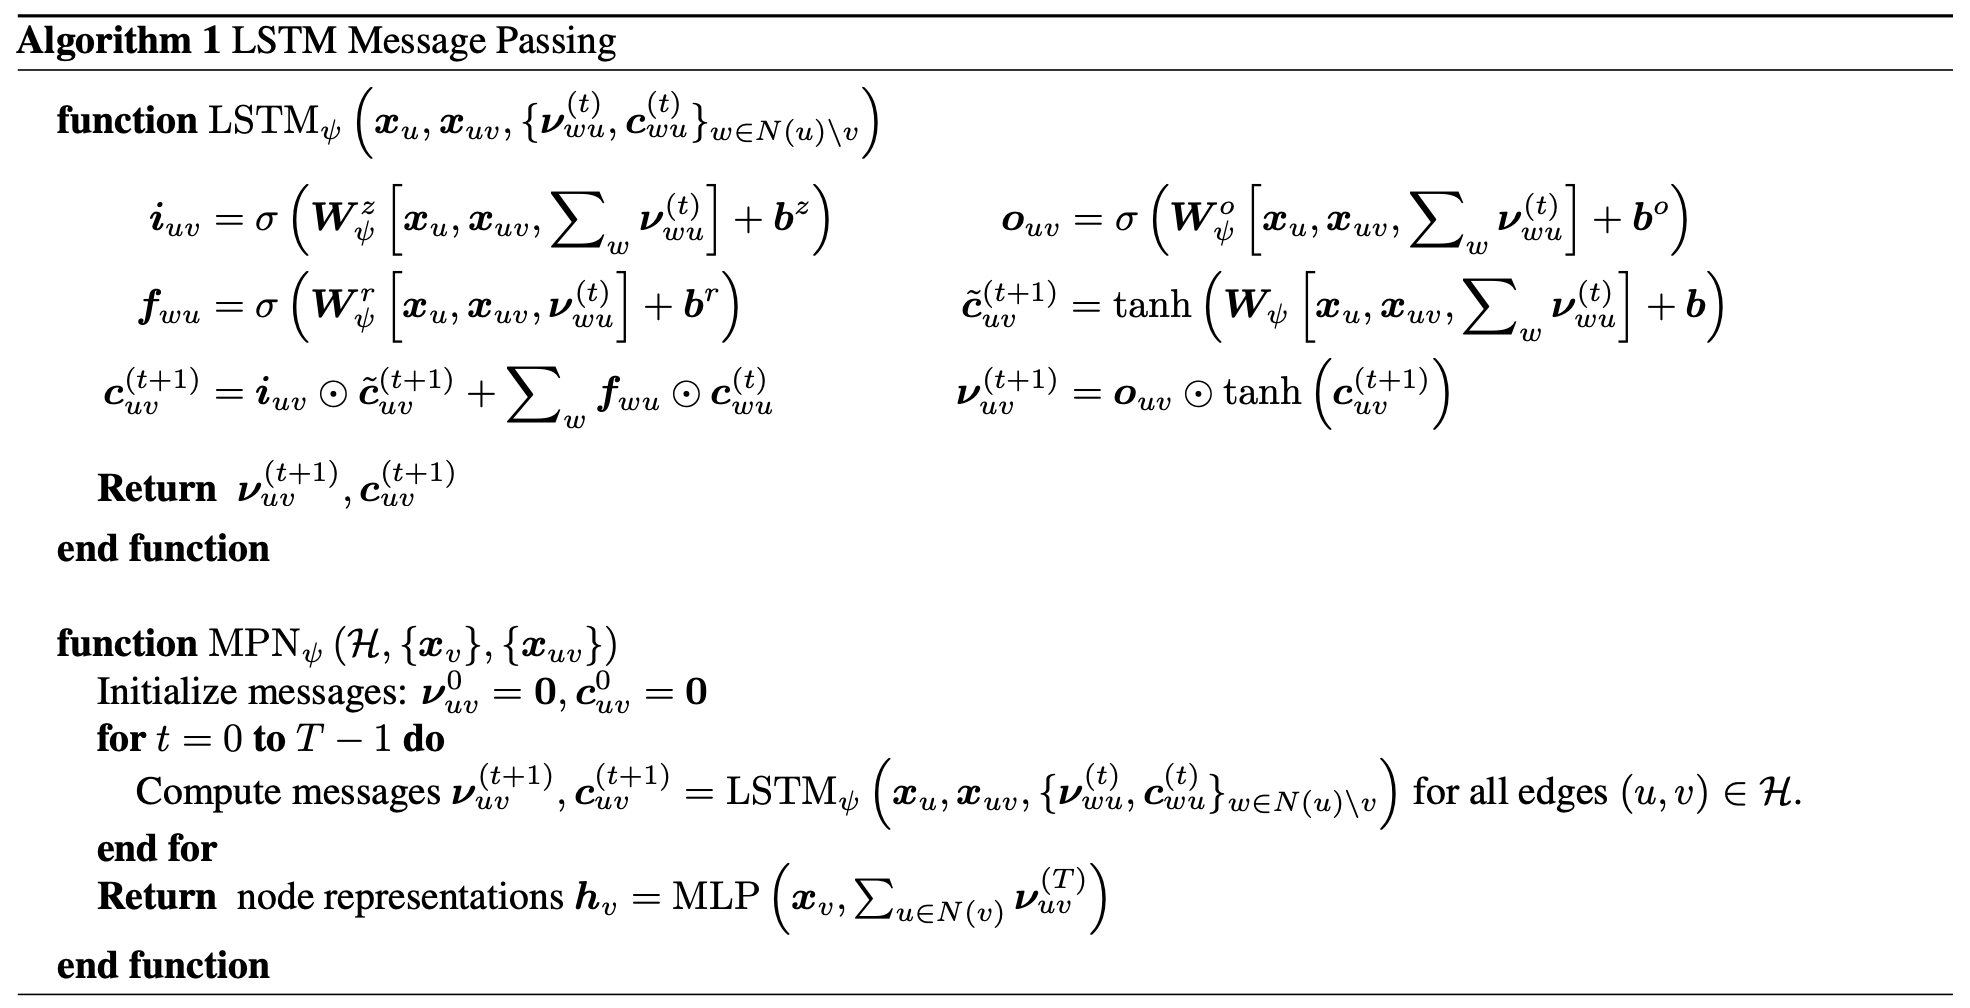

In [10]:

class GRU(nn.Module):

    def __init__(self, input_size, hidden_size, depth):
        super(GRU, self).__init__()
        self.hidden_size = hidden_size
        self.input_size = input_size
        self.depth = depth # Determine how many rounds of message passing is needed. If depth too high, then the message over the whole graph shall be the same. So normally dont do it

        self.W_z = nn.Linear(input_size + hidden_size, hidden_size)
        self.W_r = nn.Linear(input_size, hidden_size, bias=False)
        self.U_r = nn.Linear(hidden_size, hidden_size)
        self.W_h = nn.Linear(input_size + hidden_size, hidden_size)

    def get_init_state(self, fmess, init_state=None):
        # initial state filled with all 0
        h = torch.zeros(len(fmess), self.hidden_size, device=fmess.device)
        return h if init_state is None else torch.cat( (h, init_state), dim=0)

    def get_hidden_state(self, h):
        return h

    def GRU(self, x, h_nei):
        # h_nei (num_bonds, num_max_bonds, hidden_size), x (num_bonds, input_size)
        sum_h = h_nei.sum(dim=1) # The information passed from neighbors (num_bonds, hidden_size)
        z_input = torch.cat([x,sum_h], dim=1) # concate information from neighbor and origin bond or node information
        # dim = (num_bonds, hidden_size + input_size)
        z = torch.sigmoid(self.W_z(z_input)) # (num_bonds, hidden_size)

        r_1 = self.W_r(x).view(-1, 1, self.hidden_size)
        r_2 = self.U_r(h_nei) # (num_bonds, num_max_bonds, hidden_size)
        r = torch.sigmoid(r_1 + r_2) # add r_1 to each of the num_max_bonds dim of r_2. (num_bonds, num_max_bonds, hidden_size)
        
        gated_h = r * h_nei # (num_bonds, num_max_bonds, hidden_size) * (num_bonds, num_max_bonds, hidden_size) elementwise multiplication
        # the gate r handle portion of current message to mix with node or edge features. 
        sum_gated_h = gated_h.sum(dim=1) # (num_bonds, hidden_size)
        h_input = torch.cat([x,sum_gated_h], dim=1)  # dim = (num_bonds, hidden_size + input_size)
        pre_h = torch.tanh(self.W_h(h_input)) # (num_bonds, hidden_size)
        new_h = (1.0 - z) * sum_h + z * pre_h # (num_bonds, hidden_size)
        # Here z is the gate which has value between 0 and 1, sum_h is the untransformed previous message information from neighbors
        # pre_h is a mixture of current information from neighbors and node or edge features.
        #new_h = message from neighbor * (1.0 - z) + mixture of message from neighbor and node or edge features * z
        # It is to control how much information from the node or edge features and the transformed message from neighbors with the 
        # purely previous information from neighbors.
        return new_h

    def forward(self, fmess, bgraph):
        h = torch.zeros(fmess.size(0), self.hidden_size, device=fmess.device)
        mask = torch.ones(h.size(0), 1, device=h.device) #(num_bonds, 1)
        mask[0, 0] = 0 #first line of message is padding, so if index to the first line then means from an empty bond

        for i in range(self.depth):
            # passing how many times of message. 
            h_nei = index_select_ND(h, 0, bgraph)
            h = self.GRU(fmess, h_nei)
            h = h * mask # (num_bonds, hidden_size)
        return h

    def sparse_forward(self, h, fmess, submess, bgraph):
        mask = h.new_ones(h.size(0)).scatter_(0, submess, 0) # h.size(0) = num_bonds submess is the source tensor dim = (num_bonds,) only row in submess will be filled with 0
        h = h * mask.unsqueeze(1) #(num_bonds, hidden_size) * (num_bonds, 1)
        # The hidden message will be updated. The rows in index in submess will be replaced by 0. They are empty nodes
        for i in range(self.depth):
            h_nei = index_select_ND(h, 0, bgraph)
            sub_h = self.GRU(fmess, h_nei)
            h = index_scatter(sub_h, h, submess)
        return h

class LSTM(nn.Module):

    def __init__(self, input_size, hidden_size, depth):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.input_size = input_size
        self.depth = depth

        self.W_i = nn.Sequential( nn.Linear(input_size + hidden_size, hidden_size), nn.Sigmoid() )
        self.W_o = nn.Sequential( nn.Linear(input_size + hidden_size, hidden_size), nn.Sigmoid() )
        self.W_f = nn.Sequential( nn.Linear(input_size + hidden_size, hidden_size), nn.Sigmoid() )
        self.W = nn.Sequential( nn.Linear(input_size + hidden_size, hidden_size), nn.Tanh() )

    def get_init_state(self, fmess, init_state=None):
        h = torch.zeros(len(fmess), self.hidden_size, device=fmess.device)
        c = torch.zeros(len(fmess), self.hidden_size, device=fmess.device)
        if init_state is not None:
            h = torch.cat( (h, init_state), dim=0)
            c = torch.cat( (c, torch.zeros_like(init_state)), dim=0)
        return h,c

    def get_hidden_state(self, h):
        return h[0]

    def LSTM(self, x, h_nei, c_nei):
        h_sum_nei = h_nei.sum(dim=1)
        x_expand = x.unsqueeze(1).expand(-1, h_nei.size(1), -1)
        i = self.W_i( torch.cat([x, h_sum_nei], dim=-1) )
        o = self.W_o( torch.cat([x, h_sum_nei], dim=-1) )
        f = self.W_f( torch.cat([x_expand, h_nei], dim=-1) )
        u = self.W( torch.cat([x, h_sum_nei], dim=-1) )
        c = i * u + (f * c_nei).sum(dim=1)
        h = o * torch.tanh(c)
        return h, c

    def forward(self, fmess, bgraph):
        h = torch.zeros(fmess.size(0), self.hidden_size, device=fmess.device)
        c = torch.zeros(fmess.size(0), self.hidden_size, device=fmess.device)
        mask = torch.ones(h.size(0), 1, device=h.device)
        mask[0, 0] = 0 #first message is padding

        for i in range(self.depth):
            h_nei = index_select_ND(h, 0, bgraph)
            c_nei = index_select_ND(c, 0, bgraph)
            h,c = self.LSTM(fmess, h_nei, c_nei)
            h = h * mask
            c = c * mask
        return h,c

    def sparse_forward(self, h, fmess, submess, bgraph):
        h,c = h
        mask = h.new_ones(h.size(0)).scatter_(0, submess, 0)
        h = h * mask.unsqueeze(1)
        c = c * mask.unsqueeze(1)
        for i in range(self.depth):
            h_nei = index_select_ND(h, 0, bgraph)
            c_nei = index_select_ND(c, 0, bgraph)
            sub_h, sub_c = self.LSTM(fmess, h_nei, c_nei)
            h = index_scatter(sub_h, h, submess)
            c = index_scatter(sub_c, c, submess)
        return h,c


# The below cell is for the encoder part

In [1]:
import torch
import torch.nn as nn
import rdkit.Chem as Chem
import torch.nn.functional as F
class MPNEncoder(nn.Module):

    def __init__(self, rnn_type, input_size, node_fdim, hidden_size, depth, dropout):
        super(MPNEncoder, self).__init__()
        self.hidden_size = hidden_size
        self.input_size = input_size
        self.depth = depth
        self.W_o = nn.Sequential( 
                nn.Linear(node_fdim + hidden_size, hidden_size), 
                nn.ReLU(),
                nn.Dropout(dropout)
        )

        if rnn_type == 'GRU':
            self.rnn = GRU(input_size, hidden_size, depth) 
        elif rnn_type == 'LSTM':
            self.rnn = LSTM(input_size, hidden_size, depth) 
        else:
            raise ValueError('unsupported rnn cell type ' + rnn_type)

    def forward(self, fnode, fmess, agraph, bgraph):
        h = self.rnn(fmess, bgraph)
        h = self.rnn.get_hidden_state(h) # the message is aggregated on bonds. num_bonds >= num_nodes (num_bonds, hidden_size)
        nei_message = index_select_ND(h, 0, agraph) # use this message (num_nodes, max_num_bonds, hidden_size)
        nei_message = nei_message.sum(dim=1) #(num_nodes,  hidden_size)
        node_hiddens = torch.cat([fnode, nei_message], dim=1)#(num_nodes, node_feature_size + hidden_size)
        node_hiddens = self.W_o(node_hiddens) #(num_nodes, hidden_size)

        mask = torch.ones(node_hiddens.size(0), 1, device=fnode.device)  #(num_nodes, 1)
        mask[0, 0] = 0 #first node is padding
        return node_hiddens * mask, h #return only the hidden state (different from IncMPNEncoder in LSTM case)

class HierMPNEncoder(nn.Module):

    def __init__(self, vocab, avocab, rnn_type, embed_size, hidden_size, depthT, depthG, dropout):
        super(HierMPNEncoder, self).__init__()
        self.vocab = vocab
        self.hidden_size = hidden_size
        self.dropout = dropout
        self.atom_size = atom_size = avocab.size()
        self.bond_size = bond_size = len(MolGraph.BOND_LIST) + MolGraph.MAX_POS # 4 +20

        self.E_c = nn.Sequential(
                nn.Embedding(vocab.size()[0], embed_size), # embedded vocab into a continuous vector where vocab [0] is the unique cluster smiles
                nn.Dropout(dropout)
        )
        self.E_i = nn.Sequential(
                nn.Embedding(vocab.size()[1], embed_size),# embedded vocab into a continuous vector where vocab [1] is the unique intersection smiles
                nn.Dropout(dropout)
        )
        self.W_c = nn.Sequential( 
                nn.Linear(embed_size + hidden_size, hidden_size), 
                nn.ReLU(),
                nn.Dropout(dropout)
        )
        self.W_i = nn.Sequential( 
                nn.Linear(embed_size + hidden_size, hidden_size), 
                nn.ReLU(),
                nn.Dropout(dropout)
        )

        self.E_a = torch.eye(atom_size).cuda() 
        self.E_b = torch.eye( len(MolGraph.BOND_LIST) ).cuda()
        self.E_apos = torch.eye( MolGraph.MAX_POS ).cuda()
        self.E_pos = torch.eye( MolGraph.MAX_POS ).cuda()

        self.W_root = nn.Sequential( 
                nn.Linear(hidden_size * 2, hidden_size), 
                nn.Tanh() #root activation is tanh
        )
        # Three different encoders with hierachcy structure
        self.tree_encoder = MPNEncoder(rnn_type, hidden_size + MolGraph.MAX_POS, hidden_size, hidden_size, depthT, dropout)
        self.inter_encoder = MPNEncoder(rnn_type, hidden_size + MolGraph.MAX_POS, hidden_size, hidden_size, depthT, dropout)
        self.graph_encoder = MPNEncoder(rnn_type, atom_size + bond_size, atom_size, hidden_size, depthG, dropout)

    def tie_embedding(self, other):
        self.E_c, self.E_i = other.E_c, other.E_i
        self.E_a, self.E_b = other.E_a, other.E_b
        
    def embed_graph(self, graph_tensors):
        fnode, fmess, agraph, bgraph, _ = graph_tensors
        # fnode dim = (num_of_atoms, 1) content = the index of atom from vocab object
        # fmess = (u, v, attr[0], attr[1]) or (u, v, attr[0], 0). for mol_graph attr = bond_type or (bond_type, child_order) it is for atoms only in child cluster
        # normally edge_num >= node_num for a fully connected graph
        
        hnode = self.E_a.index_select(index=fnode, dim=0) # get a matrix with each row is a one hot vector. (num_of_atoms, atom_size)
        fmess1 = hnode.index_select(index=fmess[:, 0], dim=0) # Get the node one hot vector for each of the edge index on the begin node
        fmess2 = self.E_b.index_select(index=fmess[:, 2], dim=0) # Get the bond one hot vector index on the bond_type of each edge
        fpos = self.E_apos.index_select(index=fmess[:, 3], dim=0) # Get the atom position one hot vector index on the order of the child_order in the mol_tree
        hmess = torch.cat([fmess1, fmess2, fpos], dim=-1) # fmess 1 dim= (num_edges, avocab.size()), fmess2 dim = (num_edges, len(MolGraph.BOND_LIST)), fpos dim = (num_edges, MolGraph.MAX_POS)
        # hmess dim = (num_edges, avocab.size()+ len(MolGraph.BOND_LIST) + MolGraph.MAX_POS)
        return hnode, hmess, agraph, bgraph
    
    def embed_inter(self, tree_tensors, hatom):
        fnode, fmess, agraph, bgraph, cgraph, _ = tree_tensors
        # fnode = (index of the vocab smiles, index of ismiles) * num_nodes dim = (num_tree_nodes, 2)
        # cgraph dim = (num_of_nodes in a batch graph, max_cluster_size)
        # fmess = (u, v, attr[0], attr[1]) or (u, v, attr[0], 0) for mol_tree it shall be (u,v,order,0)
        finput = self.E_i(fnode[:, 1]) # get the embedding vector of index of ismiles. (num_tree_nodes, embed_size)

        hnode = index_select_ND(hatom, 0, cgraph).sum(dim=1) # hatom is the hidden information from atom layer after atom encoder
        # hatom dim = (num_nodes or num_atoms, hidden_size)
        # hnode dim = (num_tree_nodes, max_cluster_size, hidden_size ) with sum -> (num_tree_nodes, hidden_size )
        hnode = self.W_i( torch.cat([finput, hnode], dim=-1) )# (num_tree_nodes,  hidden_size + embed_size ) -> (num_tree_nodes, hidden_size)

        hmess = hnode.index_select(index=fmess[:, 0], dim=0) # index on the start node of an edge. (num_edges, hidden_size)
        pos_vecs = self.E_pos.index_select(0, fmess[:, 2]) # index on the edge order. select the one hot vector of pos for each edge (num_edges, MolGraph.MAX_POS) 
        hmess = torch.cat( [hmess, pos_vecs], dim=-1 ) # (num_edges,  hidden_size + MolGraph.MAX_POS)
        return hnode, hmess, agraph, bgraph

    def embed_tree(self, tree_tensors, hinter):
        # hinter is the hidden information from the attachment layer
        fnode, fmess, agraph, bgraph, cgraph, _ = tree_tensors
        finput = self.E_c(fnode[:, 0])  # get the embedding vector of index of smiles. (num_tree_nodes, embed_size)
        hnode = self.W_c( torch.cat([finput, hinter], dim=-1) ) # (num_tree_nodes, hidden_size + embed_size) -> (num_tree_nodes, hidden_size)

        hmess = hnode.index_select(index=fmess[:, 0], dim=0) # index on the start node of an edge. (num_edges, hidden_size)
        pos_vecs = self.E_pos.index_select(0, fmess[:, 2]) # index on the edge order. select the one hot vector of pos for each edge (num_edges, MolGraph.MAX_POS) 
        hmess = torch.cat( [hmess, pos_vecs], dim=-1 ) # (num_edges,  hidden_size + MolGraph.MAX_POS)
        return hnode, hmess, agraph, bgraph
    


    def embed_root(self, hmess, tree_tensors, roots):
        #roots is the tree_node_idx in offset of a scope which is the start idx of a tree len(roots) = num_batch
        # agraph dim  (num_nodes, max_nei) 
        roots = tree_tensors[2].new_tensor(roots) # tree_tensors[2] is agraph, the new_tensor is just to ensure the roots has the same torch device as agraph
        fnode = tree_tensors[0].index_select(0, roots)# tree_tensors[0] is hnode (num_tree_nodes, hidden_size). Index on root, (num_root, hidden_size)
        agraph = tree_tensors[2].index_select(0, roots)# get the root nei. (num_root, max_nei)

        nei_message = index_select_ND(hmess, 0, agraph) # Get nei_mess to root node. (num_root, max_nei, hidden_size)
        nei_message = nei_message.sum(dim=1) # (num_root, hidden_size)
        node_hiddens = torch.cat([fnode, nei_message], dim=1) # (num_root, hidden_size  + hidden_size)
        return self.W_root(node_hiddens)

    def forward(self, tree_tensors, graph_tensors):
        tensors = self.embed_graph(graph_tensors)
        hatom,_ = self.graph_encoder(*tensors)
        # atom layer finish

        tensors = self.embed_inter(tree_tensors, hatom)
        hinter,_ = self.inter_encoder(*tensors)
        # attachment layer finish

        tensors = self.embed_tree(tree_tensors, hinter)
        hnode,hmess = self.tree_encoder(*tensors)
        # motif layer finish hnode is node_hidden (num_nodes, hidden_size) hmess is the message hidden (num_edges, hidden_size) 
        hroot = self.embed_root(hmess, tensors, [st for st,le in tree_tensors[-1]]) # tree_tensors[-1] =(offset, len(G))

        return hroot, hnode, hinter, hatom
    
# The below is for step by step decoding. After each step of decoding, the previous decoded part shall be encoded.

class IncMPNEncoder(MPNEncoder):

    def __init__(self, rnn_type, input_size, node_fdim, hidden_size, depth, dropout):
        super(IncMPNEncoder, self).__init__(rnn_type, input_size, node_fdim, hidden_size, depth, dropout)

    def forward(self, tensors, h, num_nodes, subset):
        fnode, fmess, agraph, bgraph = tensors
        subnode, submess = subset

        if len(submess) > 0: 
            h = self.rnn.sparse_forward(h, fmess, submess, bgraph)

        nei_message = index_select_ND(self.rnn.get_hidden_state(h), 0, agraph)
        nei_message = nei_message.sum(dim=1)
        node_hiddens = torch.cat([fnode, nei_message], dim=1)
        node_hiddens = self.W_o(node_hiddens)

        node_buf = torch.zeros(num_nodes, self.hidden_size, device=fmess.device) # num_nodes is the total num_of_nodes
        node_hiddens = index_scatter(node_hiddens, node_buf, subnode) # node_hiddens are sub_data, node_buf is all_data. Only the node_hiddens in subnode will be maintained.
        return node_hiddens, h

class IncHierMPNEncoder(HierMPNEncoder):

    def __init__(self, vocab, avocab, rnn_type, embed_size, hidden_size, depthT, depthG, dropout):
        super(IncHierMPNEncoder, self).__init__(vocab, avocab, rnn_type, embed_size, hidden_size, depthT, depthG, dropout)
        self.tree_encoder = IncMPNEncoder(rnn_type, hidden_size + MolGraph.MAX_POS, hidden_size, hidden_size, depthT, dropout)
        self.inter_encoder = IncMPNEncoder(rnn_type, hidden_size + MolGraph.MAX_POS, hidden_size, hidden_size, depthT, dropout)
        self.graph_encoder = IncMPNEncoder(rnn_type, self.atom_size + self.bond_size, self.atom_size, hidden_size, depthG, dropout)
        del self.W_root

    def get_sub_tensor(self, tensors, subset):
        subnode, submess = subset # subnode and submess is a list of idx of nodes and edges
        fnode, fmess, agraph, bgraph = tensors[:4]
        fnode, fmess = fnode.index_select(0, subnode), fmess.index_select(0, submess)
        agraph, bgraph = agraph.index_select(0, subnode), bgraph.index_select(0, submess)
        # Get the subinformation from the graph decoded up to current step

        if len(tensors) == 6:
            cgraph = tensors[4].index_select(0, subnode) # get the cluster graph from tree also into sub form
            return fnode, fmess, agraph, bgraph, cgraph, tensors[-1]
        else:
            return fnode, fmess, agraph, bgraph, tensors[-1]

    def embed_sub_tree(self, tree_tensors, hinput, subtree, is_inter_layer):
        subnode, submess = subtree
        num_nodes = tree_tensors[0].size(0)
        fnode, fmess, agraph, bgraph, cgraph, _ = self.get_sub_tensor(tree_tensors, subtree)

        if is_inter_layer:
            finput = self.E_i(fnode[:, 1])
            hinput = index_select_ND(hinput, 0, cgraph).sum(dim=1)
            hnode = self.W_i( torch.cat([finput, hinput], dim=-1) )
        else:
            finput = self.E_c(fnode[:, 0])
            hinput = hinput.index_select(0, subnode)
            hnode = self.W_c( torch.cat([finput, hinput], dim=-1) )

        if len(submess) == 0:
            hmess = fmess
        else:
            node_buf = torch.zeros(num_nodes, self.hidden_size, device=fmess.device)
            node_buf = index_scatter(hnode, node_buf, subnode)
            hmess = node_buf.index_select(index=fmess[:, 0], dim=0)
            pos_vecs = self.E_pos.index_select(0, fmess[:, 2])
            hmess = torch.cat( [hmess, pos_vecs], dim=-1 ) 
        return hnode, hmess, agraph, bgraph 

    def forward(self, tree_tensors, inter_tensors, graph_tensors, htree, hinter, hgraph, subtree, subgraph):
        num_tree_nodes = tree_tensors[0].size(0)
        num_graph_nodes = graph_tensors[0].size(0)

        if len(subgraph[0]) + len(subgraph[1]) > 0:
            sub_graph_tensors = self.get_sub_tensor(graph_tensors, subgraph)[:-1] #graph tensor is already embedded
            hgraph.node, hgraph.mess = self.graph_encoder(sub_graph_tensors, hgraph.mess, num_graph_nodes, subgraph)

        if len(subtree[0]) + len(subtree[1]) > 0:
            sub_inter_tensors = self.embed_sub_tree(inter_tensors, hgraph.node, subtree, is_inter_layer=True)
            hinter.node, hinter.mess = self.inter_encoder(sub_inter_tensors, hinter.mess, num_tree_nodes, subtree)

            sub_tree_tensors = self.embed_sub_tree(tree_tensors, hinter.node, subtree, is_inter_layer=False)
            htree.node, htree.mess = self.tree_encoder(sub_tree_tensors, htree.mess, num_tree_nodes, subtree)

        return htree, hinter, hgraph

/Users/lijiali/opt/anaconda3/envs/OpenMaterial/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# The below cell is for the decoder part

In [2]:
class HTuple():
    def __init__(self, node=None, mess=None, vmask=None, emask=None):
        self.node, self.mess = node, mess
        self.vmask, self.emask = vmask, emask

class HierMPNDecoder(nn.Module):

    def __init__(self, vocab, avocab, rnn_type, embed_size, hidden_size, latent_size, depthT, depthG, dropout, attention=False):
        super(HierMPNDecoder, self).__init__()
        self.vocab = vocab # pair vocab for tree. 
        self.avocab = avocab # atom vocab for graph
        self.hidden_size = hidden_size 
        self.embed_size = embed_size
        self.latent_size = latent_size
        self.use_attention = attention
        self.itensor = torch.LongTensor([]).cuda()

        self.hmpn = IncHierMPNEncoder(vocab, avocab, rnn_type, embed_size, hidden_size, depthT, depthG, dropout) # for incremental graph
        self.rnn_cell = self.hmpn.tree_encoder.rnn
        self.E_assm = self.hmpn.E_i # the attachment layer vocab
        self.E_order = torch.eye(MolGraph.MAX_POS).cuda() # the order of cluster in child for tree structure

        self.topoNN = nn.Sequential(
                nn.Linear(hidden_size + latent_size, hidden_size),
                nn.ReLU(),
                nn.Dropout(dropout),
                nn.Linear(hidden_size, 1)
        ) 
        self.clsNN = nn.Sequential(
                nn.Linear(hidden_size + latent_size, hidden_size),
                nn.ReLU(),
                nn.Dropout(dropout),
                nn.Linear(hidden_size, vocab.size()[0])
        ) #motif pred
        self.iclsNN = nn.Sequential(
                nn.Linear(hidden_size + latent_size, hidden_size),
                nn.ReLU(),
                nn.Dropout(dropout),
                nn.Linear(hidden_size, vocab.size()[1])
        ) # attachment pred
        self.matchNN = nn.Sequential(
                nn.Linear(hidden_size + embed_size + MolGraph.MAX_POS, hidden_size),
                nn.ReLU(),
        )
        self.W_assm = nn.Linear(hidden_size, latent_size)

        if latent_size != hidden_size:
            self.W_root = nn.Linear(latent_size, hidden_size)

        if self.use_attention:
            self.A_topo = nn.Linear(hidden_size, latent_size)
            self.A_cls = nn.Linear(hidden_size, latent_size)
            self.A_assm = nn.Linear(hidden_size, latent_size)

        self.topo_loss = nn.BCEWithLogitsLoss(size_average=False)
        self.cls_loss = nn.CrossEntropyLoss(size_average=False)
        self.icls_loss = nn.CrossEntropyLoss(size_average=False)
        self.assm_loss = nn.CrossEntropyLoss(size_average=False)
        
    def apply_tree_mask(self, tensors, cur, prev):
        fnode, fmess, agraph, bgraph, cgraph, scope = tensors
        agraph = agraph * index_select_ND(cur.emask, 0, agraph)
        bgraph = bgraph * index_select_ND(cur.emask, 0, bgraph)
        cgraph = cgraph * index_select_ND(prev.vmask, 0, cgraph)
        return fnode, fmess, agraph, bgraph, cgraph, scope

    def apply_graph_mask(self, tensors, hgraph):
        fnode, fmess, agraph, bgraph, scope = tensors
        agraph = agraph * index_select_ND(hgraph.emask, 0, agraph)
        bgraph = bgraph * index_select_ND(hgraph.emask, 0, bgraph)
        return fnode, fmess, agraph, bgraph, scope

    def update_graph_mask(self, graph_batch, new_atoms, hgraph):
        new_atom_index = hgraph.vmask.new_tensor(new_atoms)
        hgraph.vmask.scatter_(0, new_atom_index, 1)

        new_atom_set = set(new_atoms)
        new_bonds = [] #new bonds are the subgraph induced by new_atoms
        for zid in new_atoms:
            for nid in graph_batch[zid]:
                if nid not in new_atom_set: continue
                new_bonds.append( graph_batch[zid][nid]['mess_idx'] )

        new_bond_index = hgraph.emask.new_tensor(new_bonds)
        if len(new_bonds) > 0:
            hgraph.emask.scatter_(0, new_bond_index, 1)
        return new_atom_index, new_bond_index

    def init_decoder_state(self, tree_batch, tree_tensors, src_root_vecs):
        batch_size = len(src_root_vecs)
        num_mess = len(tree_tensors[1])
        agraph = tree_tensors[2].clone()
        bgraph = tree_tensors[3].clone()

        for i,tup in enumerate(tree_tensors[-1]):
            root = tup[0]
            assert agraph[root,-1].item() == 0
            agraph[root,-1] = num_mess + i
            for v in tree_batch.successors(root):
                mess_idx = tree_batch[root][v]['mess_idx'] 
                assert bgraph[mess_idx,-1].item() == 0
                bgraph[mess_idx,-1] = num_mess + i

        new_tree_tensors = tree_tensors[:2] + [agraph, bgraph] + tree_tensors[4:]
        htree = HTuple()
        htree.mess = self.rnn_cell.get_init_state(tree_tensors[1], src_root_vecs)
        htree.emask = torch.cat( [bgraph.new_zeros(num_mess), bgraph.new_ones(batch_size)], dim=0 )

        return htree, new_tree_tensors

    def attention(self, src_vecs, batch_idx, queries, W_att):
        size = batch_idx.size()
        if batch_idx.dim() > 1:
            batch_idx = batch_idx.view(-1)
            queries = queries.view(-1, queries.size(-1))

        src_vecs = src_vecs.index_select(0, batch_idx)
        att_score = torch.bmm( src_vecs, W_att(queries).unsqueeze(-1) )
        att_vecs = F.softmax(att_score, dim=1) * src_vecs
        att_vecs = att_vecs.sum(dim=1)
        return att_vecs if len(size) == 1 else att_vecs.view(size[0], size[1], -1)

    def get_topo_score(self, src_tree_vecs, batch_idx, topo_vecs):
        if self.use_attention:
            topo_cxt = self.attention(src_tree_vecs, batch_idx, topo_vecs, self.A_topo)
        else:
            topo_cxt = src_tree_vecs.index_select(index=batch_idx, dim=0)
        return self.topoNN( torch.cat([topo_vecs, topo_cxt], dim=-1) ).squeeze(-1)

    def get_cls_score(self, src_tree_vecs, batch_idx, cls_vecs, cls_labs):
        if self.use_attention:
            cls_cxt = self.attention(src_tree_vecs, batch_idx, cls_vecs, self.A_cls)
        else:
            cls_cxt = src_tree_vecs.index_select(index=batch_idx, dim=0)

        cls_vecs = torch.cat([cls_vecs, cls_cxt], dim=-1)
        cls_scores = self.clsNN(cls_vecs)

        if cls_labs is None: #inference mode
            icls_scores = self.iclsNN(cls_vecs) #no masking
        else:
            vocab_masks = self.vocab.get_mask(cls_labs)
            icls_scores = self.iclsNN(cls_vecs) + vocab_masks #apply mask by log(x + mask): mask=0 or -INF
        return cls_scores, icls_scores

    def get_assm_score(self, src_graph_vecs, batch_idx, assm_vecs):
        if self.use_attention:
            assm_cxt = self.attention(src_graph_vecs, batch_idx, assm_vecs, self.A_assm)
        else:
            assm_cxt = index_select_ND(src_graph_vecs, 0, batch_idx)
        return (self.W_assm(assm_vecs) * assm_cxt).sum(dim=-1)

    def forward(self, src_mol_vecs, graphs, tensors, orders):
        # The src_mol_vecs is a tuple with three components = (a,b,c). These vectors came from the encoder part
        # orders is a list of lists of tuple. Each list in list is for one molecule  
        # Each tuple record for a tree, which node will be visited after a node in a depth-first search. [[(x,y,1),(),()],[]]
        batch_size = len(orders) # number of molecules in a batch
        tree_batch, graph_batch = graphs #nx graph object
        tree_tensors, graph_tensors = tensors # all tensors. (fnode, fmess, agraph, bgraph, scope)
        inter_tensors = tree_tensors # attachment tensor including cgraph

        src_root_vecs, src_tree_vecs, src_graph_vecs = src_mol_vecs # resampled latent information from encoder. 
        init_vecs = src_root_vecs if self.latent_size == self.hidden_size else self.W_root(src_root_vecs) 
        # self.W_root = nn.Linear(latent_size, hidden_size) change latent size to be hidden size

        htree, tree_tensors = self.init_decoder_state(tree_batch, tree_tensors, init_vecs)
        hinter = HTuple(
            mess = self.rnn_cell.get_init_state(inter_tensors[1]),
            emask = self.itensor.new_zeros(inter_tensors[1].size(0))
        )
        hgraph = HTuple(
            mess = self.rnn_cell.get_init_state(graph_tensors[1]),
            vmask = self.itensor.new_zeros(graph_tensors[0].size(0)),
            emask = self.itensor.new_zeros(graph_tensors[1].size(0))
        )
        
        all_topo_preds, all_cls_preds, all_assm_preds = [], [], []
        new_atoms = []
        tree_scope = tree_tensors[-1]
        for i in range(batch_size):
            root = tree_batch.nodes[ tree_scope[i][0] ]
            clab, ilab = self.vocab[ root['label'] ]
            all_cls_preds.append( (init_vecs[i], i, clab, ilab) ) #cluster prediction
            new_atoms.extend(root['cluster'])

        subgraph = self.update_graph_mask(graph_batch, new_atoms, hgraph)
        graph_tensors = self.hmpn.embed_graph(graph_tensors) + (graph_tensors[-1],) #preprocess graph tensors

        maxt = max([len(x) for x in orders])
        max_cls_size = max( [len(attr) * 2 for node,attr in tree_batch.nodes(data='cluster')] )

        for t in range(maxt):
            batch_list = [i for i in range(batch_size) if t < len(orders[i])]
            assert htree.emask[0].item() == 0 and hinter.emask[0].item() == 0 and hgraph.vmask[0].item() == 0 and hgraph.emask[0].item() == 0

            subtree = [], []
            for i in batch_list:
                xid, yid, tlab = orders[i][t]
                subtree[0].append(xid)
                if yid is not None:
                    mess_idx = tree_batch[xid][yid]['mess_idx']
                    subtree[1].append(mess_idx)

            subtree = htree.emask.new_tensor(subtree[0]), htree.emask.new_tensor(subtree[1]) 
            htree.emask.scatter_(0, subtree[1], 1)
            hinter.emask.scatter_(0, subtree[1], 1)

            cur_tree_tensors = self.apply_tree_mask(tree_tensors, htree, hgraph)
            cur_inter_tensors = self.apply_tree_mask(inter_tensors, hinter, hgraph)
            cur_graph_tensors = self.apply_graph_mask(graph_tensors, hgraph)
            htree, hinter, hgraph = self.hmpn(cur_tree_tensors, cur_inter_tensors, cur_graph_tensors, htree, hinter, hgraph, subtree, subgraph)

            new_atoms = []
            for i in batch_list:
                xid, yid, tlab = orders[i][t]
                all_topo_preds.append( (htree.node[xid], i, tlab) ) #topology prediction
                if yid is not None:
                    mess_idx = tree_batch[xid][yid]['mess_idx']
                    new_atoms.extend( tree_batch.nodes[yid]['cluster'] ) #NOTE: regardless of tlab = 0 or 1

                if tlab == 0: continue

                cls = tree_batch.nodes[yid]['smiles']
                clab, ilab = self.vocab[ tree_batch.nodes[yid]['label'] ]
                mess_idx = tree_batch[xid][yid]['mess_idx']
                hmess = self.rnn_cell.get_hidden_state(htree.mess)
                all_cls_preds.append( (hmess[mess_idx], i, clab, ilab) ) #cluster prediction using message
                
                inter_label = tree_batch.nodes[yid]['inter_label']
                inter_label = [ (pos, self.vocab[(cls, icls)][1]) for pos,icls in inter_label ]
                inter_size = self.vocab.get_inter_size(ilab)

                if len(tree_batch.nodes[xid]['cluster']) > 2: #uncertainty occurs only when previous cluster is a ring
                    nth_child = tree_batch[yid][xid]['label'] #must be yid -> xid (graph order labeling is different from tree)
                    cands = tree_batch.nodes[yid]['assm_cands']
                    icls = list(zip(*inter_label))[1]
                    cand_vecs = self.enum_attach(hgraph, cands, icls, nth_child)

                    if len(cand_vecs) < max_cls_size:
                        pad_len = max_cls_size - len(cand_vecs)
                        cand_vecs = F.pad(cand_vecs, (0,0,0,pad_len))

                    batch_idx = hgraph.emask.new_tensor( [i] * max_cls_size )
                    all_assm_preds.append( (cand_vecs, batch_idx, 0) ) #the label is always the first of assm_cands

            subgraph = self.update_graph_mask(graph_batch, new_atoms, hgraph)

        topo_vecs, batch_idx, topo_labels = zip_tensors(all_topo_preds)
        topo_scores = self.get_topo_score(src_tree_vecs, batch_idx, topo_vecs)
        topo_loss = self.topo_loss(topo_scores, topo_labels.float())
        topo_acc = get_accuracy_bin(topo_scores, topo_labels)

        cls_vecs, batch_idx, cls_labs, icls_labs = zip_tensors(all_cls_preds)
        cls_scores, icls_scores = self.get_cls_score(src_tree_vecs, batch_idx, cls_vecs, cls_labs)
        cls_loss = self.cls_loss(cls_scores, cls_labs) + self.icls_loss(icls_scores, icls_labs)
        cls_acc = get_accuracy(cls_scores, cls_labs)
        icls_acc = get_accuracy(icls_scores, icls_labs)

        if len(all_assm_preds) > 0:
            assm_vecs, batch_idx, assm_labels = zip_tensors(all_assm_preds)
            assm_scores = self.get_assm_score(src_graph_vecs, batch_idx, assm_vecs)
            assm_loss = self.assm_loss(assm_scores, assm_labels)
            assm_acc = get_accuracy_sym(assm_scores, assm_labels)
        else:
            assm_loss, assm_acc = 0, 1
        
        loss = (topo_loss + cls_loss + assm_loss) / batch_size
        return loss, cls_acc, icls_acc, topo_acc, assm_acc

    def enum_attach(self, hgraph, cands, icls, nth_child):
        cands = self.itensor.new_tensor(cands)
        icls_vecs = self.itensor.new_tensor(icls * len(cands))
        icls_vecs = self.E_assm( icls_vecs )

        nth_child = self.itensor.new_tensor([nth_child] * len(cands.view(-1)))
        order_vecs = self.E_order.index_select(0, nth_child)

        cand_vecs = hgraph.node.index_select(0, cands.view(-1))
        cand_vecs = torch.cat( [cand_vecs, icls_vecs, order_vecs], dim=-1 )
        cand_vecs = self.matchNN(cand_vecs)

        if len(icls) == 2:
            cand_vecs = cand_vecs.view(-1, 2, self.hidden_size).sum(dim=1)
        return cand_vecs

    def decode(self, src_mol_vecs, greedy=True, max_decode_step=100, beam=5):
        # The src_mol_vecs is a tuple with three components = (a,b,c). These vectors came from the encoder part
        
        src_root_vecs, src_tree_vecs, src_graph_vecs = src_mol_vecs
        batch_size = len(src_root_vecs)

        tree_batch = IncTree(batch_size, node_fdim=2, edge_fdim=3)
        graph_batch = IncGraph(self.avocab, batch_size, node_fdim=self.hmpn.atom_size, edge_fdim=self.hmpn.atom_size + self.hmpn.bond_size)
        stack = [[] for i in range(batch_size)]

        init_vecs = src_root_vecs if self.latent_size == self.hidden_size else self.W_root(src_root_vecs)
        batch_idx = self.itensor.new_tensor(range(batch_size))
        cls_scores, icls_scores = self.get_cls_score(src_tree_vecs, batch_idx, init_vecs, None)
        root_cls = cls_scores.max(dim=-1)[1]
        icls_scores = icls_scores + self.vocab.get_mask(root_cls)
        root_cls, root_icls = root_cls.tolist(), icls_scores.max(dim=-1)[1].tolist()

        super_root = tree_batch.add_node() 
        for bid in range(batch_size):
            clab, ilab = root_cls[bid], root_icls[bid]
            root_idx = tree_batch.add_node( batch_idx.new_tensor([clab, ilab]) )
            tree_batch.add_edge(super_root, root_idx) 
            stack[bid].append(root_idx)

            root_smiles = self.vocab.get_ismiles(ilab)
            new_atoms, new_bonds, attached = graph_batch.add_mol(bid, root_smiles, [], 0)
            tree_batch.register_cgraph(root_idx, new_atoms, new_bonds, attached)
        
        #invariance: tree_tensors is equal to inter_tensors (but inter_tensor's init_vec is 0)
        tree_tensors = tree_batch.get_tensors()
        graph_tensors = graph_batch.get_tensors()

        htree = HTuple( mess = self.rnn_cell.get_init_state(tree_tensors[1]) )
        hinter = HTuple( mess = self.rnn_cell.get_init_state(tree_tensors[1]) )
        hgraph = HTuple( mess = self.rnn_cell.get_init_state(graph_tensors[1]) )
        h = self.rnn_cell.get_hidden_state(htree.mess)
        h[1 : batch_size + 1] = init_vecs #wiring root (only for tree, not inter)
        
        for t in range(max_decode_step):
            batch_list = [ bid for bid in range(batch_size) if len(stack[bid]) > 0 ]
            if len(batch_list) == 0: break

            batch_idx = batch_idx.new_tensor(batch_list)
            cur_tree_nodes = [stack[bid][-1] for bid in batch_list]
            subtree = batch_idx.new_tensor(cur_tree_nodes), batch_idx.new_tensor([])
            subgraph = batch_idx.new_tensor( tree_batch.get_cluster_nodes(cur_tree_nodes) ), batch_idx.new_tensor( tree_batch.get_cluster_edges(cur_tree_nodes) )

            htree, hinter, hgraph = self.hmpn(tree_tensors, tree_tensors, graph_tensors, htree, hinter, hgraph, subtree, subgraph)
            topo_scores = self.get_topo_score(src_tree_vecs, batch_idx, htree.node.index_select(0, subtree[0]))
            topo_scores = torch.sigmoid(topo_scores)
            if greedy:
                topo_preds = topo_scores.tolist()
            else:
                topo_preds = torch.bernoulli(topo_scores).tolist()

            new_mess = []
            expand_list = []
            for i,bid in enumerate(batch_list):
                if topo_preds[i] > 0.5 and tree_batch.can_expand(stack[bid][-1]):
                    expand_list.append( (len(new_mess), bid) )
                    new_node = tree_batch.add_node() #new node label is yet to be predicted
                    edge_feature = batch_idx.new_tensor( [stack[bid][-1], new_node, 0] ) #parent to child is 0
                    new_edge = tree_batch.add_edge(stack[bid][-1], new_node, edge_feature) 
                    stack[bid].append(new_node)
                    new_mess.append(new_edge)
                else:
                    child = stack[bid].pop()
                    if len(stack[bid]) > 0:
                        nth_child = tree_batch.graph.in_degree(stack[bid][-1]) #edge child -> father has not established
                        edge_feature = batch_idx.new_tensor( [child, stack[bid][-1], nth_child] )
                        new_edge = tree_batch.add_edge(child, stack[bid][-1], edge_feature)
                        new_mess.append(new_edge)

            subtree = subtree[0], batch_idx.new_tensor(new_mess)
            subgraph = [], []
            htree, hinter, hgraph = self.hmpn(tree_tensors, tree_tensors, graph_tensors, htree, hinter, hgraph, subtree, subgraph)
            cur_mess = self.rnn_cell.get_hidden_state(htree.mess).index_select(0, subtree[1])

            if len(expand_list) > 0:
                idx_in_mess, expand_list = zip(*expand_list)
                idx_in_mess = batch_idx.new_tensor( idx_in_mess )
                expand_idx = batch_idx.new_tensor( expand_list )
                forward_mess = cur_mess.index_select(0, idx_in_mess)
                cls_scores, icls_scores = self.get_cls_score(src_tree_vecs, expand_idx, forward_mess, None)
                scores, cls_topk, icls_topk = hier_topk(cls_scores, icls_scores, self.vocab, beam)
                if not greedy:
                    scores = torch.exp(scores) #score is output of log_softmax
                    shuf_idx = torch.multinomial(scores, beam, replacement=True).tolist()

            for i,bid in enumerate(expand_list):
                new_node, fa_node = stack[bid][-1], stack[bid][-2]
                success = False
                cls_beam = range(beam) if greedy else shuf_idx[i]
                for kk in cls_beam: #try until one is chemically valid
                    if success: break
                    clab, ilab = cls_topk[i][kk], icls_topk[i][kk]
                    node_feature = batch_idx.new_tensor( [clab, ilab] )
                    tree_batch.set_node_feature(new_node, node_feature)
                    smiles, ismiles = self.vocab.get_smiles(clab), self.vocab.get_ismiles(ilab)
                    fa_cluster, _, fa_used = tree_batch.get_cluster(fa_node)
                    inter_cands, anchor_smiles, attach_points = graph_batch.get_assm_cands(fa_cluster, fa_used, ismiles)

                    if len(inter_cands) == 0:
                        continue
                    elif len(inter_cands) == 1:
                        sorted_cands = [(inter_cands[0], 0)]
                        nth_child = 0
                    else:
                        nth_child = tree_batch.graph.in_degree(fa_node)
                        icls = [self.vocab[ (smiles,x) ][1] for x in anchor_smiles]
                        cands = inter_cands if len(attach_points) <= 2 else [ (x[0],x[-1]) for x in inter_cands ]
                        cand_vecs = self.enum_attach(hgraph, cands, icls, nth_child)

                        batch_idx = batch_idx.new_tensor( [bid] * len(inter_cands) )
                        assm_scores = self.get_assm_score(src_graph_vecs, batch_idx, cand_vecs).tolist()
                        sorted_cands = sorted( list(zip(inter_cands, assm_scores)), key = lambda x:x[1], reverse=True )

                    for inter_label,_ in sorted_cands:
                        inter_label = list(zip(inter_label, attach_points))
                        if graph_batch.try_add_mol(bid, ismiles, inter_label):
                            new_atoms, new_bonds, attached = graph_batch.add_mol(bid, ismiles, inter_label, nth_child)
                            tree_batch.register_cgraph(new_node, new_atoms, new_bonds, attached)
                            tree_batch.update_attached(fa_node, inter_label)
                            success = True
                            break

                if not success: #force backtrack
                    child = stack[bid].pop() #pop the dummy new_node which can't be added
                    nth_child = tree_batch.graph.in_degree(stack[bid][-1]) 
                    edge_feature = batch_idx.new_tensor( [child, stack[bid][-1], nth_child] )
                    new_edge = tree_batch.add_edge(child, stack[bid][-1], edge_feature)

                    child = stack[bid].pop() 
                    if len(stack[bid]) > 0:
                        nth_child = tree_batch.graph.in_degree(stack[bid][-1]) 
                        edge_feature = batch_idx.new_tensor( [child, stack[bid][-1], nth_child] )
                        new_edge = tree_batch.add_edge(child, stack[bid][-1], edge_feature)

        return graph_batch.get_mol()

# The below cell is for the whole hgnn including decoder and encoder

In [ ]:
def make_cuda(tensors):
    tree_tensors, graph_tensors = tensors
    make_tensor = lambda x: x if type(x) is torch.Tensor else torch.tensor(x)
    tree_tensors = [make_tensor(x).cuda().long() for x in tree_tensors[:-1]] + [tree_tensors[-1]]
    graph_tensors = [make_tensor(x).cuda().long() for x in graph_tensors[:-1]] + [graph_tensors[-1]]
    return tree_tensors, graph_tensors


class HierVAE(nn.Module):

    def __init__(self, args):
        super(HierVAE, self).__init__()
        self.encoder = HierMPNEncoder(args.vocab, args.atom_vocab, args.rnn_type, args.embed_size, args.hidden_size, args.depthT, args.depthG, args.dropout)
        self.decoder = HierMPNDecoder(args.vocab, args.atom_vocab, args.rnn_type, args.embed_size, args.hidden_size, args.latent_size, args.diterT, args.diterG, args.dropout)
        self.encoder.tie_embedding(self.decoder.hmpn)
        self.latent_size = args.latent_size

        self.R_mean = nn.Linear(args.hidden_size, args.latent_size)
        self.R_var = nn.Linear(args.hidden_size, args.latent_size)

    def rsample(self, z_vecs, W_mean, W_var, perturb=True):
        # This is a typical vae resampling functions
        batch_size = z_vecs.size(0)
        z_mean = W_mean(z_vecs) # change hidden_size dim to latent_size. (num_of_something, latent_size)
        z_log_var = -torch.abs( W_var(z_vecs) )# (num_of_something, latent_size)
        kl_loss = -0.5 * torch.sum(1.0 + z_log_var - z_mean * z_mean - torch.exp(z_log_var)) / batch_size # calculate KL divergence https://stats.stackexchange.com/questions/318748/deriving-the-kl-divergence-loss-for-vaes/370048#370048
        epsilon = torch.randn_like(z_mean).cuda()
        z_vecs = z_mean + torch.exp(z_log_var / 2) * epsilon if perturb else z_mean # sample in latent
        return z_vecs, kl_loss

    def sample(self, batch_size, greedy):
        root_vecs = torch.randn(batch_size, self.latent_size).cuda()
        return self.decoder.decode((root_vecs, root_vecs, root_vecs), greedy=greedy, max_decode_step=150)

    def reconstruct(self, batch):
        graphs, tensors, _ = batch
        tree_tensors, graph_tensors = tensors = make_cuda(tensors)
        root_vecs, tree_vecs, _, graph_vecs = self.encoder(tree_tensors, graph_tensors) # vector size = (num of something, hidden_size)

        root_vecs, root_kl = self.rsample(root_vecs, self.R_mean, self.R_var, perturb=False) # sample conditioned on root_vecs
        return self.decoder.decode((root_vecs, root_vecs, root_vecs), greedy=True, max_decode_step=150)
       
    def forward(self, graphs, tensors, orders, beta, perturb_z=True):
        # it is for training 
        tree_tensors, graph_tensors = tensors = make_cuda(tensors)

        root_vecs, tree_vecs, _, graph_vecs = self.encoder(tree_tensors, graph_tensors) # hroot, hnode, hinter, hatom
        # encoder part to encode an input molecule
        root_vecs, root_kl = self.rsample(root_vecs, self.R_mean, self.R_var, perturb_z)# sample latent vector conditioned on information provided from the input molecule
        kl_div = root_kl # calculate the KL 

        loss, wacc, iacc, tacc, sacc = self.decoder((root_vecs, root_vecs, root_vecs), graphs, tensors, orders) # generate new molecules from a root node.
        return loss + beta * kl_div, kl_div.item(), wacc, iacc, tacc, sacc


class HierVGNN(nn.Module):

    def __init__(self, args):
        super(HierVGNN, self).__init__()
        self.latent_size = args.latent_size
        self.encoder = HierMPNEncoder(args.vocab, args.atom_vocab, args.rnn_type, args.embed_size, args.hidden_size, args.depthT, args.depthG, args.dropout)
        self.decoder = HierMPNDecoder(args.vocab, args.atom_vocab, args.rnn_type, args.embed_size, args.hidden_size, args.hidden_size, args.diterT, args.diterG, args.dropout, attention=True)
        self.encoder.tie_embedding(self.decoder.hmpn)

        self.T_mean = nn.Linear(args.hidden_size, args.latent_size)
        self.T_var = nn.Linear(args.hidden_size, args.latent_size)
        self.G_mean = nn.Linear(args.hidden_size, args.latent_size)
        self.G_var = nn.Linear(args.hidden_size, args.latent_size)

        self.W_tree = nn.Sequential( nn.Linear(args.hidden_size + args.latent_size, args.hidden_size), nn.ReLU() )
        self.W_graph = nn.Sequential( nn.Linear(args.hidden_size + args.latent_size, args.hidden_size), nn.ReLU() )

    def encode(self, tensors):
        tree_tensors, graph_tensors = tensors
        root_vecs, tree_vecs, _, graph_vecs = self.encoder(tree_tensors, graph_tensors)
        tree_vecs = stack_pad_tensor( [tree_vecs[st : st + le] for st,le in tree_tensors[-1]] )
        graph_vecs = stack_pad_tensor( [graph_vecs[st : st + le] for st,le in graph_tensors[-1]] )
        return root_vecs, tree_vecs, graph_vecs

    def translate(self, tensors, num_decode, enum_root, greedy=True):
        tensors = make_cuda(tensors)
        root_vecs, tree_vecs, graph_vecs = self.encode(tensors)
        all_smiles = []
        if enum_root:
            repeat = num_decode // len(root_vecs)
            modulo = num_decode % len(root_vecs)
            root_vecs = torch.cat([root_vecs] * repeat + [root_vecs[:modulo]], dim=0)
            tree_vecs = torch.cat([tree_vecs] * repeat + [tree_vecs[:modulo]], dim=0)
            graph_vecs = torch.cat([graph_vecs] * repeat + [graph_vecs[:modulo]], dim=0)
        
        batch_size = len(root_vecs)
        z_tree = torch.randn(batch_size, 1, self.latent_size).expand(-1, tree_vecs.size(1), -1).cuda()
        z_graph = torch.randn(batch_size, 1, self.latent_size).expand(-1, graph_vecs.size(1), -1).cuda()
        z_tree_vecs = self.W_tree( torch.cat([tree_vecs, z_tree], dim=-1) )
        z_graph_vecs = self.W_graph( torch.cat([graph_vecs, z_graph], dim=-1) )
        return self.decoder.decode( (root_vecs, z_tree_vecs, z_graph_vecs), greedy=greedy)

    def rsample(self, z_vecs, W_mean, W_var):
        batch_size = z_vecs.size(0)
        z_mean = W_mean(z_vecs)
        z_log_var = -torch.abs( W_var(z_vecs) )
        kl_loss = -0.5 * torch.sum(1.0 + z_log_var - z_mean * z_mean - torch.exp(z_log_var)) / batch_size
        epsilon = torch.randn_like(z_mean).cuda()
        z_vecs = z_mean + torch.exp(z_log_var / 2) * epsilon
        return z_vecs, kl_loss

    def forward(self, x_graphs, x_tensors, y_graphs, y_tensors, y_orders, beta):
        x_tensors = make_cuda(x_tensors)
        y_tensors = make_cuda(y_tensors)
        x_root_vecs, x_tree_vecs, x_graph_vecs = self.encode(x_tensors)
        _, y_tree_vecs, y_graph_vecs = self.encode(y_tensors)

        diff_tree_vecs = y_tree_vecs.sum(dim=1) - x_tree_vecs.sum(dim=1)
        diff_graph_vecs = y_graph_vecs.sum(dim=1) - x_graph_vecs.sum(dim=1)
        diff_tree_vecs, tree_kl = self.rsample(diff_tree_vecs, self.T_mean, self.T_var)
        diff_graph_vecs, graph_kl = self.rsample(diff_graph_vecs, self.G_mean, self.G_var)
        kl_div = tree_kl + graph_kl

        diff_tree_vecs = diff_tree_vecs.unsqueeze(1).expand(-1, x_tree_vecs.size(1), -1)
        diff_graph_vecs = diff_graph_vecs.unsqueeze(1).expand(-1, x_graph_vecs.size(1), -1)
        x_tree_vecs = self.W_tree( torch.cat([x_tree_vecs, diff_tree_vecs], dim=-1) )
        x_graph_vecs = self.W_graph( torch.cat([x_graph_vecs, diff_graph_vecs], dim=-1) )

        loss, wacc, iacc, tacc, sacc = self.decoder((x_root_vecs, x_tree_vecs, x_graph_vecs), y_graphs, y_tensors, y_orders)
        return loss + beta * kl_div, kl_div.item(), wacc, iacc, tacc, sacc

class HierCondVGNN(HierVGNN):

    def __init__(self, args):
        super(HierCondVGNN, self).__init__(args)
        self.W_tree = nn.Sequential( nn.Linear(args.hidden_size + args.latent_size + args.cond_size, args.hidden_size), nn.ReLU() )
        self.W_graph = nn.Sequential( nn.Linear(args.hidden_size + args.latent_size + args.cond_size, args.hidden_size), nn.ReLU() )

        self.U_tree = nn.Sequential( nn.Linear(args.hidden_size + args.cond_size, args.hidden_size), nn.ReLU() )
        self.U_graph = nn.Sequential( nn.Linear(args.hidden_size + args.cond_size, args.hidden_size), nn.ReLU() )

    def translate(self, tensors, cond, num_decode, enum_root):
        assert enum_root 
        tensors = make_cuda(tensors)
        root_vecs, tree_vecs, graph_vecs = self.encode(tensors)

        cond = cond.view(1,1,-1)
        tree_cond = cond.expand(num_decode, tree_vecs.size(1), -1)
        graph_cond = cond.expand(num_decode, graph_vecs.size(1), -1)

        if enum_root:
            repeat = num_decode // len(root_vecs)
            modulo = num_decode % len(root_vecs)
            root_vecs = torch.cat([root_vecs] * repeat + [root_vecs[:modulo]], dim=0)
            tree_vecs = torch.cat([tree_vecs] * repeat + [tree_vecs[:modulo]], dim=0)
            graph_vecs = torch.cat([graph_vecs] * repeat + [graph_vecs[:modulo]], dim=0)

        z_tree = torch.randn(num_decode, 1, self.latent_size).expand(-1, tree_vecs.size(1), -1).cuda()
        z_graph = torch.randn(num_decode, 1, self.latent_size).expand(-1, graph_vecs.size(1), -1).cuda()
        z_tree_vecs = self.W_tree( torch.cat([tree_vecs, z_tree, tree_cond], dim=-1) )
        z_graph_vecs = self.W_graph( torch.cat([graph_vecs, z_graph, graph_cond], dim=-1) )
        return self.decoder.decode( (root_vecs, z_tree_vecs, z_graph_vecs) )

    def forward(self, x_graphs, x_tensors, y_graphs, y_tensors, y_orders, cond, beta):
        x_tensors = make_cuda(x_tensors)
        y_tensors = make_cuda(y_tensors)
        cond = torch.tensor(cond).float().cuda()

        x_root_vecs, x_tree_vecs, x_graph_vecs = self.encode(x_tensors)
        _, y_tree_vecs, y_graph_vecs = self.encode(y_tensors)

        diff_tree_vecs = y_tree_vecs.sum(dim=1) - x_tree_vecs.sum(dim=1)
        diff_graph_vecs = y_graph_vecs.sum(dim=1) - x_graph_vecs.sum(dim=1)
        diff_tree_vecs = self.U_tree( torch.cat([diff_tree_vecs, cond], dim=-1) ) #combine condition for posterior
        diff_graph_vecs = self.U_graph( torch.cat([diff_graph_vecs, cond], dim=-1) ) #combine condition for posterior

        diff_tree_vecs, tree_kl = self.rsample(diff_tree_vecs, self.T_mean, self.T_var)
        diff_graph_vecs, graph_kl = self.rsample(diff_graph_vecs, self.G_mean, self.G_var)
        kl_div = tree_kl + graph_kl

        diff_tree_vecs = torch.cat([diff_tree_vecs, cond], dim=-1) #combine condition for posterior
        diff_graph_vecs = torch.cat([diff_graph_vecs, cond], dim=-1) #combine condition for posterior

        diff_tree_vecs = diff_tree_vecs.unsqueeze(1).expand(-1, x_tree_vecs.size(1), -1)
        diff_graph_vecs = diff_graph_vecs.unsqueeze(1).expand(-1, x_graph_vecs.size(1), -1)
        x_tree_vecs = self.W_tree( torch.cat([x_tree_vecs, diff_tree_vecs], dim=-1) )
        x_graph_vecs = self.W_graph( torch.cat([x_graph_vecs, diff_graph_vecs], dim=-1) )

        loss, wacc, iacc, tacc, sacc = self.decoder((x_root_vecs, x_tree_vecs, x_graph_vecs), y_graphs, y_tensors, y_orders)
        return loss + beta * kl_div, kl_div.item(), wacc, iacc, tacc, sacc

## The below cell is for constructing molecule graph object

In [32]:
test_smiles = ['CCC(NC(=O)c1scnc1C1CC1)C(=O)N1CCOCC1','O=C1OCCC1Sc1nnc(-c2c[nH]c3ccccc23)n1C1CC1', 'CCN(C)S(=O)(=O)N1CCC(Nc2cccc(OC)c2)CC1', 'CC(=O)Nc1cccc(NC(C)c2ccccn2)c1', 'Cc1cc(-c2nc3sc(C4CC4)nn3c2C#N)ccc1Cl', 'CCOCCCNC(=O)c1cc(OC)ccc1Br', 'Cc1nc(-c2ccncc2)[nH]c(=O)c1CC(=O)NC1CCCC1', 'C#CCN(CC#C)C(=O)c1cc2ccccc2cc1OC(F)F', 'CCOc1ccc(CN2c3ccccc3NCC2C)cc1N', 'NC(=O)C1CCC(CNc2cc(-c3ccccc3)nc3ccnn23)CC1', 'CC1CCc2noc(NC(=O)c3cc(=O)c4ccccc4o3)c2C1', 'c1cc(-n2cnnc2)cc(-n2cnc3ccccc32)c1', 'Cc1ccc(-n2nc(C)cc2NC(=O)C2CC3C=CC2C3)nn1', 'O=c1ccc(c[nH]1)C1NCCc2ccc3OCCOc3c12']
# test_smiles = test_smiles[0]
for s in test_smiles:#test_smiles:

        #mol = Chem.MolFromSmiles(s)
        #for a in mol.GetAtoms():
        #    a.SetAtomMapNum( a.GetIdx() )
        #print(Chem.MolToSmiles(mol))

    hmol = MolGraph(s)
    # print(hmol.clusters)
    # print(list(hmol.mol_tree.edges))
    # print(nx.get_node_attributes(hmol.mol_tree, 'label'))
    # print(nx.get_node_attributes(hmol.mol_tree, 'inter_label'))
    # print(nx.get_node_attributes(hmol.mol_tree, 'assm_cands'))
    # print(hmol.order)
    print(hmol.mol_graph[8])


cluster:
(7, 6, 10, 9, 8)
/n rank:
{4: 0, 6: 5, 10: 2, 9: 3, 8: 1, 7: 4}
cands
[10, 7, 6, 9, 8]
{7: {'weight': 1, 'label': 0}, 9: {'weight': 1, 'label': 1}}
cluster:
(1, 2, 3, 4, 5)
/n rank:
{0: 0, 1: 5, 2: 4, 3: 2, 4: 1, 5: 3}
cands
[5, 1, 2, 3, 4]
cluster:
(8, 7, 20, 10, 9)
/n rank:
{6: 0, 7: 5, 8: 3, 9: 2, 10: 1, 20: 4}
cands
[10, 8, 7, 20, 9]
cluster:
(8, 7, 20, 10, 9)
/n rank:
{6: 1, 7: 6, 8: 3, 9: 2, 10: 5, 11: 0, 20: 4}
cands
[20, 8, 7, 10, 9]
{7: {'weight': 1, 'label': 1}, 9: {'weight': 1, 'label': 0}}
cluster:
(7, 21, 20, 10, 9, 8)
/n rank:
{4: 0, 7: 6, 8: 4, 9: 2, 10: 1, 20: 2, 21: 4}
cands
[10, 7, 21, 20, 9, 8]
cluster:
(13, 14, 15, 16, 19, 12)
/n rank:
{11: 0, 12: 6, 13: 4, 14: 2, 15: 1, 16: 2, 19: 4}
cands
[16, 13, 15, 19, 12]
{7: {'weight': 1, 'label': 0}, 9: {'weight': 1, 'label': 0}}
cluster:
(4, 18, 8, 7, 6, 5)
/n rank:
{3: 0, 4: 6, 5: 4, 6: 2, 7: 1, 8: 2, 18: 4}
cands
[8, 4, 18, 7, 5]
{7: {'weight': 1, 'label': 0}, 9: {'weight': 1, 'label': 0}, 18: {'weight': 1, 'labe